In [1]:
import numpy as np
import pandas as pd
import os 
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from scipy.ndimage import gaussian_filter1d
from sklearn.model_selection import train_test_split
import random
import warnings

import statistics as stat
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score 
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix

In [2]:
warnings.filterwarnings('ignore')

## 데이터 원본 경로

In [8]:
path = "../origin_data/"

## 데이터 불러오기 

In [9]:
datalist = os.listdir(path)
datalist = [file for file in datalist if '.xlsx' in file] # path 경로에서 .xlsx 가 있는 파일만 불러와서 datalist에 담기

filename = []
for file in tqdm(datalist) :
    file = file.replace(".xlsx", "") # datalist 에 불러온 파일명에서 .xlsx 지우기 
    
    # 데이터 프레임 이름을 파일 이름으로 지정 
    globals()['df_{}'.format(file)] = pd.read_excel(path + "{}.xlsx".format(file), encoding = 'cp949')
    
    # 파일에 있는 컬럼 중에서 사용할 컬럼만 지정 
    globals()['df_{}'.format(file)] = globals()['df_{}'.format(file)][['#1_snd', '#2_snd', '#3_snd', '#1_talking', '#2_talking', '#3_talking']]
    
    # 지정한 컬럼 이름을 변경 
    globals()['df_{}'.format(file)].columns = ['x1','x2','x3','y1','y2','y3'] 
    filename.append('df_' + file)

100%|██████████| 60/60 [00:38<00:00,  1.56it/s]


In [10]:
filename

['df_10th_turn_02',
 'df_1st_short_01',
 'df_13th_turn_03',
 'df_5th_short_01',
 'df_8th_short_01',
 'df_12th_turn_02',
 'df_1st_turn_01',
 'df_7th_turn_01',
 'df_3rd_turn_01',
 'df_9th_turn_03',
 'df_12th_turn_01',
 'df_3rd_turn_03',
 'df_13th_turn_02',
 'df_7th_turn_02',
 'df_10th_turn_01',
 'df_8th_turn_01',
 'df_1st_turn_02',
 'df_3rd_turn_02',
 'df_3rd_short_01',
 'df_12th turn_03',
 'df_15th_turn_03',
 'df_10th_short_01',
 'df_5th_turn_02',
 'df_15th_short_01',
 'df_4th_short_01',
 'df_4th_turn_02',
 'df_8th_turn_03',
 'df_7th_turn_03',
 'df_6th_short_01',
 'df_11th_turn_02',
 'df_13th_short_01',
 'df_15th_turn_01',
 'df_8th_turn_02',
 'df_5th_turn_03',
 'df_7th_short_01',
 'df_15th_turn_02',
 'df_2nd_short_01',
 'df_1st_turn_03',
 'df_6th_turn_02',
 'df_10th_turn_03',
 'df_14th_short_01',
 'df_14th_turn_02',
 'df_4th_turn_01',
 'df_9th_turn_02',
 'df_11th_turn_01',
 'df_6th_turn_01',
 'df_5th_turn_01',
 'df_9th_short_01',
 'df_11th_short_01',
 'df_14th_turn_03',
 'df_12th_short_

In [11]:
# 예시 (x1: person1, x2: person2, x3: person3 ; y1, y2, y3 = 0 (말하지 않음) or 1 (말함) )
df_1st_turn_01

,x1,x2,x3,y1,y2,y3
0,2056,2053,2058,0,0,0
1,2054,2058,2047,0,0,0
2,2050,2053,2050,0,0,0
3,2054,2056,2057,0,0,0
4,2048,2056,2046,0,0,0
...,...,...,...,...,...,...
9230,2054,2050,2065,0,0,1
9231,2061,2058,2069,0,0,1
9232,2044,2055,2019,0,0,1
9233,2050,2054,2040,0,0,0


In [12]:
# 전처리 전 신호 그래프 그리기

### 위에서 지정한 시나리오 파일별 이름 (ex. df_4th_turn_02)을 변수로 넣으면 person1, 2, 3 의 원본 음성 데이터와 
### 실제 발화 구간(말했음/말하지 않음)에 대한 그래프를 볼 수 있도록 함수 생성


def get_df_name(df): # 전역에서 각 시나리오 파일의 이름을 대괄호 없이 가져온다.
    name =[x for x in globals() if globals()[x] is df][0] 
    #.values()[0]
    return name

def signal_graph_origin_data(df) :
    
    df.name = get_df_name(df) # 각 데이터 프레임의 이름을 데이터 파일의 이름 (ex. df_8th_turn_01)으로 지정
    
    x1 = df['x1']  # x1을 호출하면 x1 컬럼에 해당하는 전체 row 값들이 불려진다. 
    x2 = df['x2']
    x3 = df['x3']
    y1 = df['y1']
    y2 = df['y2']
    y3 = df['y3']
    
    plt.rcParams["font.size"] = 16
    plt.rcParams["figure.figsize"] = (20, 15)

    fig = plt.figure()
    fig.subplots_adjust(wspace=0.2, hspace=0.3)
    fig.suptitle('VAD Signal graph of ' + str(df.name), fontsize=30) # 전체 제목
    
    ax1 = fig.add_subplot(4, 2, 1) 
    ax1.title.set_text("Person 1") 
    x1.plot(color=['#ff6633']) # person 1에 대한 row data 에 대한 그래프를 그려줌 

    ax2 = fig.add_subplot(4, 2, 2)
    ax2.title.set_text("Person 1 talking answer") # 실제로 사람이 말하고 있는 구간
    y1.plot(color=['#ff6633']) # person1의 실제 발화 구간을 그래프로 그려줌 (y1 = 1 or 0)

    ax3 = fig.add_subplot(4, 2, 3)
    ax3.title.set_text("Person 2")
    x2.plot(color=['#008000'])

    ax4 = fig.add_subplot(4, 2, 4)
    ax4.title.set_text("Person 2 talking answer")
    y2.plot(color=['#008000'])
    
    ax5 = fig.add_subplot(4, 2, 5)
    ax5.title.set_text("Person 3")
    x3.plot(color=['#0066ff'])
    
    ax6 = fig.add_subplot(4, 2, 6)
    ax6.title.set_text("Person 3 talking answer")
    y3.plot(color=['#0066ff'])

    ax7 = fig.add_subplot(4, 2, 7)
    ax7.title.set_text("Combined signal") # person의 음성 데이터 그래프와 발화 구간 그래프를 겹쳐서 보여줌 
    x1.plot(color=['#ff6633'])
    x2.plot(color=['#008000'])
    x3.plot(color=['#0066ff'])
    
    ax8 = fig.add_subplot(4, 2, 8) 
    ax8.title.set_text("Combined answer")
    y1.plot(color=['#ff6633'])
    y2.plot(color=['#008000'])
    y3.plot(color=['#0066ff'])
   

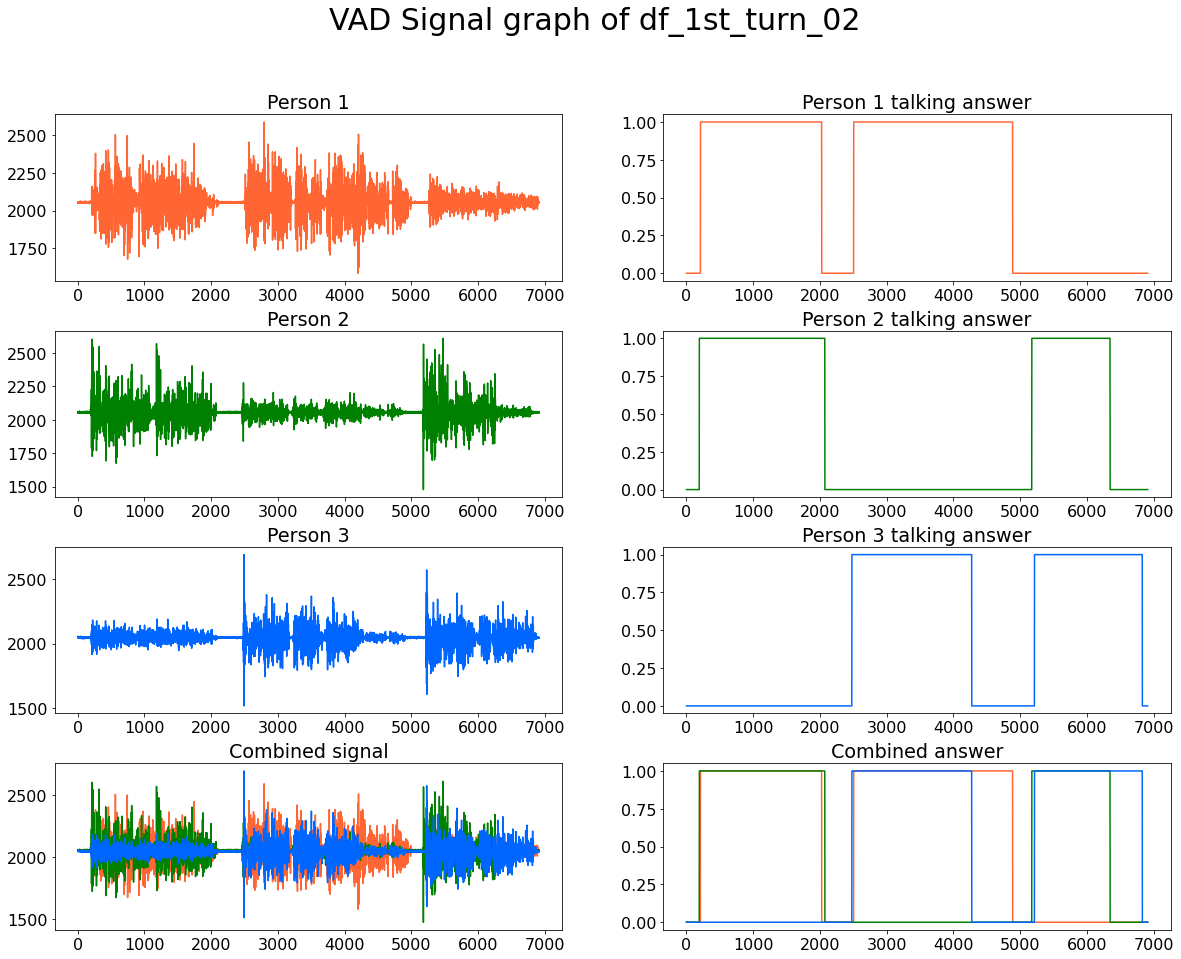

In [13]:
# 예시 : 시나리오 파일 명만 넣으면 시나리오별 person1,2,3의 음성 데이터와 발화 구간을 확인할 수 있다. 
signal_graph_origin_data(df_1st_turn_02)

## 데이터 전처리

#### 1. 데이터 정규화 function 생성: def normalization(df)
#### 2. 정규화 결과값들에 절댓값 취해주는 function 생성: def absolute(df)
#### 3. 정규화 및 절댓값 처리를 완료한 시나리오 데이터프레임의 x1, x2, x3 과 y1, y2, y3 를 각각 세로로 이어주는 function을 생성 : infile_concat(df)
#### 4. 시나리오 파일별 위의 1,2,3 을 모두 수행해 주는 function 생성: 파일별 전처리 수행 

In [14]:
# 데이터 정규화
def normalization(df) :
    x_df = df[['x1', 'x2', 'x3']]
    y_df = df[['y1', 'y2', 'y3']]
    normalized_x = (x_df - x_df.mean()) / x_df.std()
    normalized_df = pd.concat([normalized_x, y_df], axis = 1)
    
    return normalized_df    

In [15]:
# 각 시나리오 file 별로 x1, x2, x3와 y1,y2,y3를 행단위로 이어준다. 
# 데이터 형태 :
# --------------
# | [x1]  [y1] |
# | [x2]  [y2] |
# | [x3]  [y3] |
# --------------
def infile_concat(df) : 
    person_1_x = pd.concat([pd.Series(np.ones(pd.Series(df['x1']).shape[0])), pd.Series(df['x1'])], axis = 1)
    person_2_x = pd.concat([2*pd.Series(np.ones(pd.Series(df['x2']).shape[0])), pd.Series(df['x2'])], axis = 1)
    person_3_x = pd.concat([3*pd.Series(np.ones(pd.Series(df['x3']).shape[0])), pd.Series(df['x3'])], axis = 1)
    
    person_1_y = pd.Series(df['y1'])
    person_2_y = pd.Series(df['y2'])
    person_3_y = pd.Series(df['y3'])
    
    total = pd.concat([person_1_x, person_2_x, person_3_x], axis = 1)
    
    a = pd.concat([total.iloc[:,0], total.iloc[:,2], total.iloc[:,4]])
    b = pd.concat([total.iloc[:,1], total.iloc[:,3], total.iloc[:,5]])
    aa = pd.DataFrame(a).reset_index(drop=True)
    aa.columns = ['idx']
    bb = pd.DataFrame(b).reset_index(drop=True)
    bb.columns = ['signal']
#
    total_x = pd.concat([aa,bb], axis = 1).reset_index(drop=True)
    
    
    total_y = pd.concat([person_1_y, person_2_y, person_3_y]).reset_index(drop= True)
    
    infile_concated_df = pd.concat([total_x, total_y], axis = 1).reset_index(drop= True)
    infile_concated_df.columns = ['person', 'signal', 'talking']
    infile_concated_df = infile_concated_df.reset_index(drop=True)
    
    return infile_concated_df

In [16]:
# 절댓값 취하기
def absolute(df) : 
    absolute_df = np.abs(df)
    return absolute_df

In [17]:
# 위의 전처리 (정규화, 절댓값, x1x2x3 / y1y2y3 세로로 이어주기) 를 마친 파일을 p_filename 에 담아준다.
p_filename = []
for f in filename : 
    df = globals()[f]
    norm_df = normalization(df)
    abs_df = absolute(norm_df)
    concat_df = infile_concat(abs_df)
    globals()['p_{}'.format(f)] = concat_df # p_df = preprocessed data
    p_filename.append('p_' + f)

In [18]:
p_filename

['p_df_10th_turn_02',
 'p_df_1st_short_01',
 'p_df_13th_turn_03',
 'p_df_5th_short_01',
 'p_df_8th_short_01',
 'p_df_12th_turn_02',
 'p_df_1st_turn_01',
 'p_df_7th_turn_01',
 'p_df_3rd_turn_01',
 'p_df_9th_turn_03',
 'p_df_12th_turn_01',
 'p_df_3rd_turn_03',
 'p_df_13th_turn_02',
 'p_df_7th_turn_02',
 'p_df_10th_turn_01',
 'p_df_8th_turn_01',
 'p_df_1st_turn_02',
 'p_df_3rd_turn_02',
 'p_df_3rd_short_01',
 'p_df_12th turn_03',
 'p_df_15th_turn_03',
 'p_df_10th_short_01',
 'p_df_5th_turn_02',
 'p_df_15th_short_01',
 'p_df_4th_short_01',
 'p_df_4th_turn_02',
 'p_df_8th_turn_03',
 'p_df_7th_turn_03',
 'p_df_6th_short_01',
 'p_df_11th_turn_02',
 'p_df_13th_short_01',
 'p_df_15th_turn_01',
 'p_df_8th_turn_02',
 'p_df_5th_turn_03',
 'p_df_7th_short_01',
 'p_df_15th_turn_02',
 'p_df_2nd_short_01',
 'p_df_1st_turn_03',
 'p_df_6th_turn_02',
 'p_df_10th_turn_03',
 'p_df_14th_short_01',
 'p_df_14th_turn_02',
 'p_df_4th_turn_01',
 'p_df_9th_turn_02',
 'p_df_11th_turn_01',
 'p_df_6th_turn_01',
 'p_

In [19]:
# 예시
## signal 컬럼이 x1, x2, x3의 음성 데이터를 세로로 이어준것
### talking 컬럼이 y1, y2, y3 의 발화 여부 데이터를 세로로 이어준것

p_df_1st_turn_01

,person,signal,talking
0,1.0,0.048491,0.0
1,1.0,0.017960,0.0
2,1.0,0.043103,0.0
3,1.0,0.017960,0.0
4,1.0,0.073634,0.0
...,...,...,...
27700,3.0,0.435598,1.0
27701,3.0,0.538689,1.0
27702,3.0,0.749951,1.0
27703,3.0,0.208722,0.0


In [30]:
# 전처리 된 데이터 그래프 그리기 
# 데이터 합친 이후에도 사용 가능 
def get_df_name(df): 
    name =[x for x in globals() if globals()[x] is df][0]
    return name

def signal_graph(df) : 
    df.name = get_df_name(df) 
    print(df.name)
    
    signal = df['signal']
    talking = df['talking']
    
    plt.rcParams["font.size"] = 16
    plt.rcParams["figure.figsize"] = (20, 15)

    fig = plt.figure()
    fig.subplots_adjust(wspace=0.2, hspace=0.3)
    fig.suptitle('VAD Signal graph of ' + str(df.name), fontsize=30) # 전체 제목
    
    ax1 = fig.add_subplot(3, 1, 1) 
    ax1.title.set_text("signal") # x1, x2, x3의 음성 데이터를 그래프로 보여준다. 
    signal.plot()

    ax2 = fig.add_subplot(3, 1, 2)
    ax2.title.set_text("talking") # 실제로 사람이 말하고 있는 구간 (y1, y2, y3의 발화 여부 데이터를 그래프로 보여준다.)
    talking.plot(color=['#ff0000'])

    ax3 = fig.add_subplot(3, 1, 3)
    ax3.title.set_text("Combined graph")
    ax3.plot(signal)
    
    ax4 = ax3.twinx()
    ax4.plot(talking, color='#ff0000')
    ax4.set_ylim(0, 1.25)


_


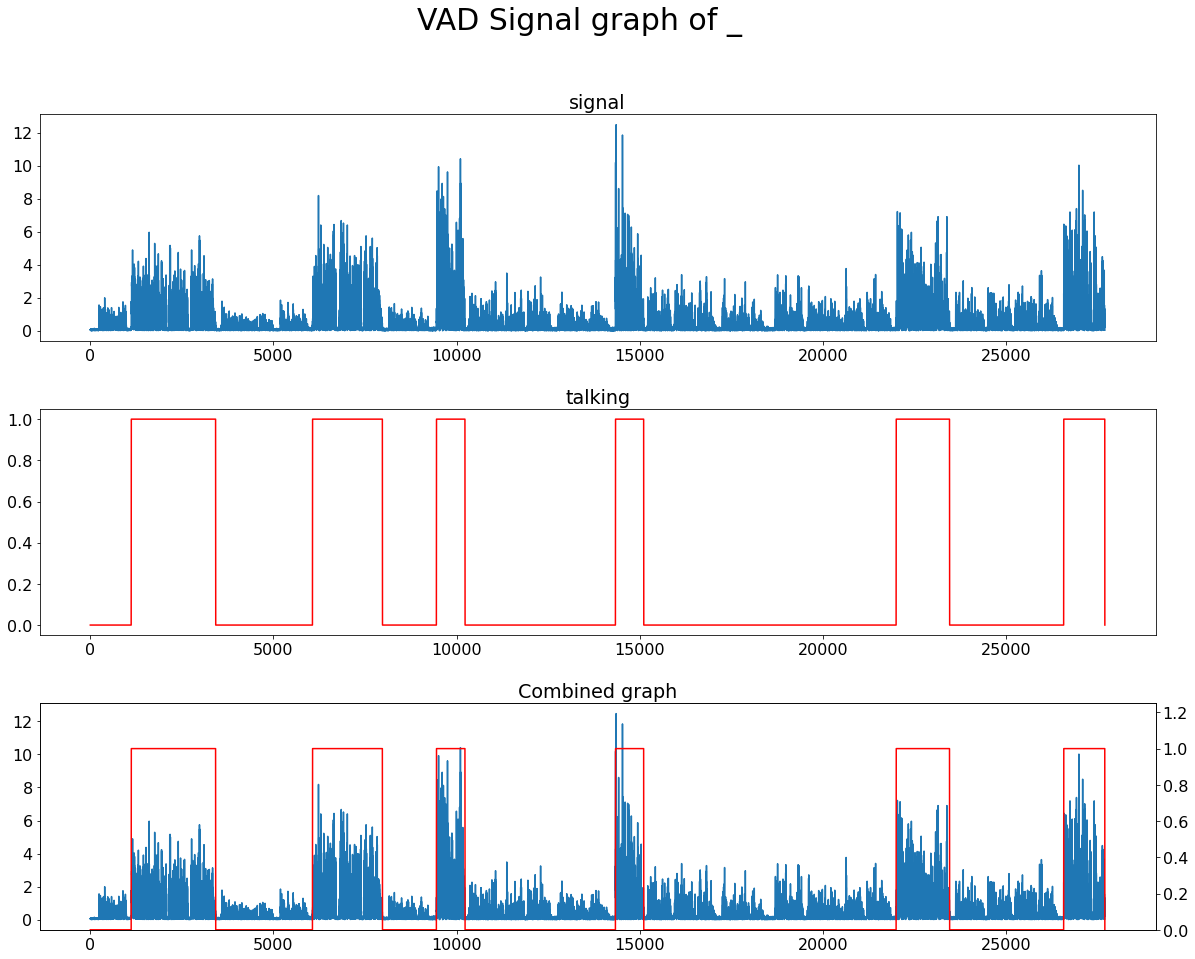

In [31]:
# 예시 
signal_graph(p_df_1st_turn_01)

### (Optional) 
##### Experiment 별로 데이터 합치기 
##### (*향후 추가 연구를 위해 다른 형태로 데이터를 합쳐 놓음)

In [32]:
# 합친 데이터 그래프 그리기
a = concat_by_experiments(p_filename, "1st")
signal_graph(a)

NameError: name 'concat_by_experiments' is not defined

## filter를 활용한 파생변수생성 

#### (1) x1, x2, x3 를 각각 25개의 필터에 넣어 새로운 변수를 생성 --> person 별로 1개의 변수에서 26개의 변수로 늘어남 
#### (2) 필터 종류
#####   - savitzky_golay(df) : 윈도우 사이즈 10 으로 조정
#####   - savitzky_golay(df) : 윈도우 사이즈 50 으로 조정
#####   - savitzky_golay(df) : 윈도우 사이즈 100 으로 조정
#####   - savitzky_golay(df) : 윈도우 사이즈 200 으로 조정
#####   - savitzky_golay(df) : 윈도우 사이즈 300 으로 조정
#####   - savitzky_golay_quadratic(df) : 윈도우 사이즈 10 으로 조정 
#####   - savitzky_golay_quadratic(df) : 윈도우 사이즈 50 으로 조정 
#####   - savitzky_golay_quadratic(df) : 윈도우 사이즈 100 으로 조정 
#####   - savitzky_golay_quadratic(df) : 윈도우 사이즈 200 으로 조정 
#####   - savitzky_golay_quadratic(df) : 윈도우 사이즈 300 으로 조정 
#####   - moving_average(df) : 윈도우 사이즈 10 으로 조정
#####   - moving_average(df) : 윈도우 사이즈 50 으로 조정
#####   - moving_average(df) : 윈도우 사이즈 100 으로 조정
#####   - moving_average(df) : 윈도우 사이즈 200 으로 조정
#####   - moving_average(df) : 윈도우 사이즈 300 으로 조정
#####   - moving_standard(df) : 윈도우 사이즈 10 으로 조정
#####   - moving_standard(df) : 윈도우 사이즈 50 으로 조정
#####   - moving_standard(df) : 윈도우 사이즈 100 으로 조정
#####   - moving_standard(df) : 윈도우 사이즈 200 으로 조정
#####   - moving_standard(df) : 윈도우 사이즈 300 으로 조정
#####   - def gaussian_fiter(df) : 윈도우 사이즈 10 으로 조정
#####   - def gaussian_fiter(df) : 윈도우 사이즈 50 으로 조정
#####   - def gaussian_fiter(df) : 윈도우 사이즈 100 으로 조정
#####   - def gaussian_fiter(df) : 윈도우 사이즈 200 으로 조정
#####   - def gaussian_fiter(df) : 윈도우 사이즈 300 으로 조정
#### --> 총 25개의 변수를 추가적으로 생성하여 Person 별로 총 26개의 변수가 존재 

In [33]:
def savitzky_golay(df) : 
    signal = df['signal']
    sa10 = pd.DataFrame(savgol_filter(signal, 11, 1))
    sa50 = pd.DataFrame(savgol_filter(signal, 51, 1))
    sa100 = pd.DataFrame(savgol_filter(signal, 101, 1))
    sa200 = pd.DataFrame(savgol_filter(signal, 201, 1))
    sa300 = pd.DataFrame(savgol_filter(signal, 301, 1))
    
    df_sa = pd.concat([sa10, sa50, sa100, sa200, sa300], axis = 1)
    df_sa.columns = ["sa10", 'sa50', 'sa100', 'sa200', 'sa300']
    return df_sa

In [34]:
def savitzky_golay_quadratic(df) :
    signal = df['signal']
    saq10 = pd.DataFrame(savgol_filter(signal, 11, 2))
    saq50 = pd.DataFrame(savgol_filter(signal, 51, 2))
    saq100 = pd.DataFrame(savgol_filter(signal, 101, 2))
    saq200 = pd.DataFrame(savgol_filter(signal, 201, 2))
    saq300 = pd.DataFrame(savgol_filter(signal, 301, 2))
    
    df_saq = pd.concat([saq10, saq50, saq100, saq200, saq300], axis = 1)
    df_saq.columns = ["saq10", 'saq50', 'saq100', 'saq200', 'saq300']
    return df_saq

In [35]:
def moving_average(df) : 
    signal = df['signal']
    ma10 = signal.rolling(10, min_periods = 1).mean().to_frame()
    ma50 = signal.rolling(50, min_periods = 1).mean().to_frame()
    ma100 = signal.rolling(100, min_periods = 1).mean().to_frame()
    ma200 = signal.rolling(200, min_periods = 1).mean().to_frame()
    ma300 = signal.rolling(300, min_periods = 1).mean().to_frame()
    
    df_ma = pd.concat([ma10, ma50, ma100, ma200, ma300], axis = 1)
    df_ma.columns = ["ma10", 'ma50', 'ma100', 'ma200', 'ma300']
    df_ma = df_ma.fillna(0)
    return df_ma

In [36]:
def moving_standard(df) : 
    signal = df['signal']
    sd10 = signal.rolling(10, min_periods = 1).std().to_frame() 
    sd50 = signal.rolling(50, min_periods = 1).std().to_frame() 
    sd100 = signal.rolling(100, min_periods = 1).std().to_frame()
    sd200 = signal.rolling(200, min_periods = 1).std().to_frame()
    sd300 = signal.rolling(300, min_periods = 1).std().to_frame()
    
    df_sd = pd.concat([sd10, sd50, sd100, sd200, sd300], axis = 1)
    df_sd.columns = ["sd10", 'sd50', 'sd100', 'sd200', 'sd300']
    df_sd = df_sd.fillna(0)
    return df_sd

In [37]:
def gaussian_fiter(df) :
    signal = df['signal']
    windows_size = [10, 50, 100, 200, 300]
    for m in windows_size :
        globals()['ga{}'.format(m)] = pd.DataFrame(gaussian_filter1d(signal, sigma =((m-1)/(2*2.5))))
    
    df_ga = pd.concat([ga10, ga50, ga100, ga200, ga300], axis = 1)
    df_ga.columns = ["ga10", 'ga50', 'ga100', 'ga200', 'ga300']
    #df_ga = df_ga.fillna(0)
    return df_ga                                          

In [39]:
# 위의 filter로 생성한 변수들을 기존 데이터프레임에 추가

def feature_generation(df) : 
    df_sa = savitzky_golay(df)
    df_saq = savitzky_golay_quadratic(df)
    df_ma = moving_average(df)
    df_sd = moving_standard(df)
    df_ga = gaussian_fiter(df)
    
    final_df = pd.concat([df, df_ga, df_sa, df_saq, df_ma, df_sd], axis = 1)
    final_df = final_df[['person', 'signal',
                         "ga10", 'ga50', 'ga100', 'ga200', 'ga300',
                         "sa10", 'sa50', 'sa100', 'sa200', 'sa300',
                         "saq10", 'saq50', 'saq100', 'saq200', 'saq300',
                         "ma10", 'ma50', 'ma100', 'ma200', 'ma300',
                         "sd10", 'sd50', 'sd100', 'sd200', 'sd300',
                         'talking']]
    return final_df

In [40]:
# 모든 시나리오 파일에 대해 파생변수 생성하여 complete_filename에 담는다. 

complete_filename = []
for f in tqdm(p_filename) : 
    df = globals()[f]
    comp_df = feature_generation(df)
    globals()['comp_{}'.format(f)] = comp_df # comp_ =complete
    complete_filename.append('comp_' + f)

100%|██████████| 60/60 [00:05<00:00, 11.88it/s]


In [41]:
complete_filename

['comp_p_df_10th_turn_02',
 'comp_p_df_1st_short_01',
 'comp_p_df_13th_turn_03',
 'comp_p_df_5th_short_01',
 'comp_p_df_8th_short_01',
 'comp_p_df_12th_turn_02',
 'comp_p_df_1st_turn_01',
 'comp_p_df_7th_turn_01',
 'comp_p_df_3rd_turn_01',
 'comp_p_df_9th_turn_03',
 'comp_p_df_12th_turn_01',
 'comp_p_df_3rd_turn_03',
 'comp_p_df_13th_turn_02',
 'comp_p_df_7th_turn_02',
 'comp_p_df_10th_turn_01',
 'comp_p_df_8th_turn_01',
 'comp_p_df_1st_turn_02',
 'comp_p_df_3rd_turn_02',
 'comp_p_df_3rd_short_01',
 'comp_p_df_12th turn_03',
 'comp_p_df_15th_turn_03',
 'comp_p_df_10th_short_01',
 'comp_p_df_5th_turn_02',
 'comp_p_df_15th_short_01',
 'comp_p_df_4th_short_01',
 'comp_p_df_4th_turn_02',
 'comp_p_df_8th_turn_03',
 'comp_p_df_7th_turn_03',
 'comp_p_df_6th_short_01',
 'comp_p_df_11th_turn_02',
 'comp_p_df_13th_short_01',
 'comp_p_df_15th_turn_01',
 'comp_p_df_8th_turn_02',
 'comp_p_df_5th_turn_03',
 'comp_p_df_7th_short_01',
 'comp_p_df_15th_turn_02',
 'comp_p_df_2nd_short_01',
 'comp_p_df_1

In [42]:
len(complete_filename)

60

## Train/Test split 

In [43]:
# 신호측정이 이상한 파일 제거 :
# 총 60개의 파일 중에서 10개의 파일이 이상함
# 50개의 시나리오 파일만 활용할 예정
## 10개의 파일을 제거한 50개의 파일을 clearfile에 담는다. 

bad_file = ['comp_p_df_12th_short_01', 'comp_p_df_14th_turn_02', 'comp_p_df_15th_turn_01', 
            'comp_p_df_15th_turn_02', 'comp_p_df_3rd_short_01', 'comp_p_df_6th_turn_02', 
            'comp_p_df_7th_short_01', 'comp_p_df_7th_turn_01', 'comp_p_df_9th_turn_01', 
            'comp_p_df_9th_turn_02']

clearfile = complete_filename.copy()
clearfile = [x for x in clearfile if x not in bad_file]

In [44]:
len(clearfile)

50

### Train, Test set 구성시 유의할 사항
##### (1) 3 개의 Train set (각각 15개의 시나리오 파일로 구성됨), 1 개의 Test set (5개의 시나리오 파일로 구성됨)
##### *def merge_dataframe (f_lst)
###### --> Train set과 1개의 Test set을 각각 구성하는 15개 시나리오, 5개의 시나리오들을 행방향으로 이어줌 
###### --> 따라서, Train set에는 총 45 개의 시나리오, Test set에는 총 5개의 시나리오가 들어가 있다. 


##### (2) 각각의 Train set, Test set에 들어갈 시나리오 종류가 고르게 들어갈 수 있도록함
######     (*종류별 시나리오를 배분할 때 random 하게 들어갈 수 있도록 코드를 짬)

In [45]:
# Train set과 Test set을 각각 구성하는 15개 시나리오, 5개의 시나리오들을 행방향으로 이어주기 위한 함수 
def merge_dataframe(f_lst): 
    for idx, f in enumerate(f_lst):
        if idx == 0:
            total_df = globals()[f]

        else:
            total_df = total_df.append(globals()[f])
            
    total_df.reset_index(drop=True)
    return total_df

In [46]:
# 각각의 Train set, Test set에 들어갈 시나리오 종류가 고르게 들어갈 수 있도록함
# *종류별 시나리오를 배분할 때 random 하게 들어갈 수 있도록 코드를 짬

# 시나리오 종류별로 묶음 = short, turn1, turn2, turn3 별로 묶음
short = [s for s in clearfile if 'short' in s]
t1 = [s for s in clearfile if 'turn_01' in s]
t2 = [s for s in clearfile if 'turn_02' in s]
t3 = [s for s in clearfile if 'turn_03' in s]

# 램덤하게 시나리오 순서를 돌려준다. 
random.shuffle(short) 
random.shuffle(t1)
random.shuffle(t2)
random.shuffle(t3)


data = []
sett = [[1,2,1,1],[5,2,3,5],[3,4,3,5],[3,4,4,4]]
# sett = [[test], [train1], [train2], [train3]] 의 구성을 의미. 각각의 대괄호 안의 숫자는 순서대로 short, turn01, turn02, turn03 의 시나리오의 개수를 의미함. 
## ex. [1, 2, 1, 1] --> short 시나리오: 1개, turn1 시나리오: 2개, turn2 시나리오: 1개, turn3 시나리오: 1개 

# 아래 s1, s2, s3, s4는 각각 [1,5,3,3], [2,2,4,4], [1,3,3,4], [1,5,5,4]를 의미 
## ex. s1 는 test, train1, train2, train3 각각의 첫 번 째 숫자를 의미 (short 시나리오 개수)
for s1,s2,s3,s4 in sett:
    fold = []
    for i in range(s1): # s1 = [1,5,3,3] 이므로 loop를 돌면서 short 시나리오를 1개, 5개, 3개, 3개를 뽑아서 fold에 저장  
        fold.append(short.pop()) # pop 을 씀으로써, 뽑은 시나리오는 삭제한다. 
    for i in range(s2):
        fold.append(t1.pop())
    for i in range(s3):
        fold.append(t2.pop())
    for i in range(s4):
        fold.append(t3.pop())
    data.append(fold)

test = merge_dataframe(data[0])    # 위의 [1,2,1,1] 데이터를 하나로 이어줌. ## testset : s1이 한 개 더 많게 배분 
train_1 = merge_dataframe(data[1]) # 위의 [5,2,3,5] 데이터를 하나로 이어줌. ## s1이 많은 trainset
train_2 = merge_dataframe(data[2]) # 위의 [3,4,3,5] 데이터를 하나로 이어줌. ## t1이 많은 trainset
train_3 = merge_dataframe(data[3]) # 위의 [3,4,4,4] 데이터를 하나로 이어줌. ## t2가 많은 trainset

In [47]:
# 랜덤하게 뽑은 train_2를 구성하는 시나리오 
## short, turn01, turn02, turn03 시나리오는 순서대로 [3,4,3,5] 가짓수만큼 존재 
data[2]

['comp_p_df_9th_short_01',
 'comp_p_df_8th_short_01',
 'comp_p_df_10th_short_01',
 'comp_p_df_6th_turn_01',
 'comp_p_df_4th_turn_01',
 'comp_p_df_3rd_turn_01',
 'comp_p_df_10th_turn_01',
 'comp_p_df_12th_turn_02',
 'comp_p_df_2nd_turn_02',
 'comp_p_df_5th_turn_02',
 'comp_p_df_12th turn_03',
 'comp_p_df_1st_turn_03',
 'comp_p_df_4th_turn_03',
 'comp_p_df_13th_turn_03',
 'comp_p_df_14th_turn_03']

In [48]:
## Train X, Y
### 위의 train_1, train_2, train_3, test 의 시그널 (x = 26개의 변수) 부분과, 발화 여부 (y = 0 or 1) 부분으로 나눠준다.  

f1_x = train_1.iloc[:, 1:-1]
f1_y = train_1.iloc[:, -1]

f2_x = train_2.iloc[:, 1:-1]
f2_y = train_2.iloc[:, -1]

f3_x = train_3.iloc[:, 1:-1]
f3_y = train_3.iloc[:, -1]

## Test X, Y 
test_x = test.iloc[:, 1:-1]
test_y = test.iloc[:, -1]

print(f1_x.shape)
print(f2_x.shape)
print(f3_x.shape)
print(test_x.shape)

train1 = (f1_x, f1_y)
train2 = (f2_x, f2_y)
train3 = (f3_x, f3_y)

(380613, 26)
(420936, 26)
(432351, 26)
(152856, 26)


## Smoothing 

#### (1) def assign_label(value)
##### --> Train, Test set의 sinal 값을 모두 0 or 0.5 or 1 값으로 변환해 준다. 
#### (2) def smoothing(pre_smth)
##### --> (1)을 통해 변형된 값을 스무딩하여, 정확한 발화 구간을 만들어 준다. 

In [49]:
def assign_label(value):
    if value >= 0.8:
        label = 1
    elif (value < 0.8) & (value > 0.5):
        label = 0.5
    else:
        label = 0
    return label

In [50]:
def smoothing(pre_smth):
    smth = np.array(pd.Series(pre_smth).apply(assign_label), dtype=np.float)  
    new_smth = smth.copy()           #np.unique(new_smth) = 0, 0.5, 1
    new_smth = pd.DataFrame(new_smth)
    new_smth.columns = ['new_smth']
    voice = new_smth[new_smth['new_smth']==1] # voice --> 데이터가 1인 것만 모아서 데이터 프레임을 만든다. 
    for i in tqdm(range(0, len(new_smth))):  
        
        if i == 0: # 첫 번째 인덱스는 지나간다. 
            continue
        elif i == len(smth)-1: # 마지막 인덱스는 지나간다.
            continue
        elif i <= int(voice.index[0]): # 현재 인덱스가 voice 의 첫 번째 인덱스보다 작거나 같으면 지나간다.  
            continue
        elif i >= int(voice.index[-1]): # 현재 인덱스가 voice 의 마지막 인덱스보다 크거나 같으면 지나간다.         
            continue
        else: 
            a = i - voice.loc[:i-1,:].index[-1] # (i) - (i 발생 전의 voice 중 가장 마지막 인덱스)
            b = voice.loc[i+1:,:].index[0] - i  # (i 이후 voice 중 가장 첫 번째 인덱스) - (i)
            if (a < 200) & (b < 200) & (a+b < 200): ## 위의 a,b 구간이 충분이 작아야 1로 변경해준다. 
                new_smth.loc[i,'new_smth'] = 1
                
    semi_voice = new_smth[new_smth['new_smth']==0.5]
    for j in tqdm(semi_voice.index):
    
        if (len(new_smth.loc[j - 200 : j:200,:][new_smth.loc[j - 200 : j:200,:]['new_smth']==1])>=1):
            new_smth.loc[j,'new_smth']=1
        else:
            new_smth.loc[j,'new_smth']=0
        
    new_voice = new_smth[new_smth['new_smth']==1]
    for i in tqdm(range(0, len(new_smth))):  #smth : 원본 
        if i == 0:
            continue
        elif i == len(smth)-1:
            continue
        elif i <= int(voice.index[0]):
            continue
        elif i >= int(voice.index[-1]):        
            continue
        else:
            a = i - new_voice.loc[:i-1,:].index[-1]
            b = new_voice.loc[i+1:,:].index[0]-i
            if (a < 200) & (b < 200) & (a+b < 200):
                new_smth.loc[i,'new_smth'] = 1
    return new_smth

In [51]:
temp = pd.DataFrame(test_y).reset_index(drop=True)
temp.columns = ['new_smth']
true_test = temp.copy()
#true_test.loc[temp[temp['new_smth']==0].index,'new_smth']=1 
#true_test.loc[temp[temp['new_smth']==1].index,'new_smth']=0
## 시나리오 데이터의 라벨은 '말하지 않음 = 0', '말함 = 1' 인데, 앞으로 사용할 분류모델은 라벨의 순서대로 (0 --> 1) 예측 결과를 보여준다. 
### 예측 결과의 첫 컬럼을 '말했을 확률'로 받기 위해서 기존 인덱스 0,1을 서로 바꿔줌 

In [52]:
test_idx = test.iloc[:, 0].reset_index(drop = True)
test_idx

0         1.0
1         1.0
2         1.0
3         1.0
4         1.0
         ... 
152851    3.0
152852    3.0
152853    3.0
152854    3.0
152855    3.0
Name: person, Length: 152856, dtype: float64

In [53]:
def turn_taking(pred): ## 스무딩 완료한 것을 넣어야함 
    a = pred['new_smth'][1:]
   
    turn_taking = 0
    for i, value in enumerate(a):
        if value - a.iloc[i-1] == -1:
            turn_taking += 1
            
    return turn_taking

In [54]:
# 모든 traing set의 turn taking 개수를 세고 원본과 비교

def total_turn_taking (t1, t2, t3, true) :
    a = turn_taking(t1)
    b = turn_taking(t2)
    c = turn_taking(t3)
    d = turn_taking(true)
    total = [a,b,c,d]
    df_total = pd.DataFrame(total, index = ['train1', 'train2', 'train3', 'true_test'])
    df_total.columns = ['turn_taking']
    
    return df_total

In [55]:
def final_graph (a,b, origin, sm_pred, true_test): #graph
    plt.figure(figsize=(40,10))
    plt.plot(origin.loc[a:b], color='tab:red')
    plt.plot(sm_pred['new_smth'].loc[a:b], color='tab:blue')
    plt.plot(true_test['new_smth'][a:b], color = 'tab:green')

## Classifier

### Result

In [56]:
# AUC function definition
def AUC(test, pred1, pred2, pred3):
    auc = (roc_auc_score(test, pred1) +roc_auc_score(test, pred2)+ roc_auc_score(test, pred3))*1/3
    auc_std = stat.stdev([roc_auc_score(test, pred1), roc_auc_score(test, pred2), roc_auc_score(test, pred3)])
    #print('AUC', auc)
    #print('AUC_std',auc_std)
    
    return auc, auc_std

In [57]:
# Accuracy function definition
def Accuracy(test, pred1, pred2, pred3):
    accur = (accuracy_score(test, pred1) + accuracy_score(test, pred2) + accuracy_score(test, pred3))*1/3 
    accur_std = stat.stdev([accuracy_score(test, pred1),  accuracy_score(test, pred2),  accuracy_score(test, pred3)])
    #print('Accuracy',accur)
    #print('Accuracy_std',accur_std )
    
    return accur, accur_std 

In [58]:
# Confusion function definition 

def Sensitivity(test, pred1, pred2, pred3):
    a = confusion_matrix(test, pred1)
    b = confusion_matrix(test, pred2)
    c = confusion_matrix(test, pred3)
    
    sen = (a[1,1]/(a[1,1] + a[1,0]) + b[1,1]/(b[1,1] + b[1,0]) + c[1,1]/(c[1,1] + c[1,0]))*1/3  
    sen_std = stat.stdev( [ a[1,1]/(a[1,1] + a[1,0]), b[1,1]/(b[1,1] + b[1,0]) ,c[1,1]/(c[1,1] + c[1,0])])
   
    #print('Sensitivity', sen)
    #print('Sensitivity_std', sen_std)
    
    return sen, sen_std

In [59]:
def Specificity(test, pred1, pred2, pred3):
    a = confusion_matrix(test, pred1)
    b = confusion_matrix(test, pred2)
    c = confusion_matrix(test, pred3)
    
    spec = (a[0,0]/(a[0,0] + a[0,1]) + b[0,0]/(b[0,0] + b[0,1]) + c[0,0]/(c[0,0] + c[0,1]) )*1/3  
    spec_std = stat.stdev([a[0,0]/(a[0,0] + a[0,1]),  b[0,0]/(b[0,0] + b[0,1]),  c[0,0]/(c[0,0] + c[0,1])])
   
    #print('Specificity', spec)
    #print('Specificity_std', spec_std)
    
    return spec, spec_std

In [60]:
def result(test, pred1, pred2, pred3): 
    m = AUC(test, pred1, pred2, pred3)
    n = Accuracy(test, pred1, pred2, pred3)
    l = Sensitivity(test, pred1, pred2, pred3)
    p = Specificity(test, pred1, pred2, pred3)
    
    rslt = [m, n, l, p]
    df_result = pd.DataFrame(rslt, index = ['AUC', 'Accuracy', 'Sensitivity', 'Specificity'])
    df_result.columns = ['result', 'std']
    
    return df_result

### New testset

In [61]:
## 기존 테스트셋 모양
test_x

,signal,ga10,ga50,ga100,ga200,ga300,sa10,sa50,sa100,sa200,...,ma10,ma50,ma100,ma200,ma300,sd10,sd50,sd100,sd200,sd300
0,0.071940,0.042469,0.034748,0.032621,0.060149,0.241283,0.043284,0.032152,0.026395,-0.320405,...,0.071940,0.071940,0.071940,0.071940,0.071940,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.006441,0.040881,0.034705,0.032617,0.060275,0.241472,0.041785,0.032167,0.026555,-0.307212,...,0.039191,0.039191,0.039191,0.039191,0.039191,0.046315,0.046315,0.046315,0.046315,0.046315
2,0.022816,0.039223,0.034621,0.032609,0.060524,0.241850,0.040285,0.032182,0.026715,-0.294019,...,0.033733,0.033733,0.033733,0.033733,0.033733,0.034087,0.034087,0.034087,0.034087,0.034087
3,0.088315,0.037860,0.034497,0.032596,0.060900,0.242419,0.038786,0.032198,0.026875,-0.280826,...,0.047378,0.047378,0.047378,0.047378,0.047378,0.038980,0.038980,0.038980,0.038980,0.038980
4,0.006441,0.036245,0.034337,0.032579,0.061405,0.243174,0.037286,0.032213,0.027035,-0.267634,...,0.039191,0.039191,0.039191,0.039191,0.039191,0.038402,0.038402,0.038402,0.038402,0.038402
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21676,0.237196,0.185608,0.176587,0.156658,0.169201,0.173505,0.197435,0.101076,0.180906,0.047613,...,0.204622,0.196888,0.162077,0.278301,0.311606,0.085786,0.182896,0.155093,0.311331,0.345982
21677,0.101558,0.172061,0.178473,0.156577,0.169188,0.173469,0.196255,0.096574,0.181260,0.045304,...,0.192291,0.194422,0.161766,0.272596,0.311625,0.091242,0.183342,0.155184,0.303940,0.345970
21678,0.101558,0.175754,0.179895,0.156520,0.169178,0.173443,0.195075,0.092071,0.181615,0.042994,...,0.183660,0.194175,0.162564,0.272042,0.311584,0.095681,0.183461,0.154661,0.304151,0.345994
21679,0.145056,0.195880,0.180846,0.156482,0.169170,0.173425,0.193895,0.087569,0.181970,0.040685,...,0.184893,0.192825,0.162875,0.268959,0.311770,0.095029,0.183571,0.154593,0.302283,0.345889


In [67]:
## 새로운 테스트셋 불러옴
new_test = pd.read_csv("../edit_test.csv")
new_test

,Time,t1_AMP,t1_VAD,t2_AMP,t2_VAD,t3_AMP,t3_VAD
0,50:42.5,2026,0,2107,0,2034,0.0
1,50:42.5,2047,0,2051,0,2042,0.0
2,50:42.5,2037,0,2013,0,2044,0.0
3,50:42.5,2035,0,2039,0,2041,0.0
4,50:42.5,2012,0,2019,0,2043,0.0
...,...,...,...,...,...,...,...
22380,54:26.3,2027,0,2040,0,2036,0.0
22381,54:26.3,2040,0,2042,0,2035,0.0
22382,54:26.3,2081,0,2053,0,2046,0.0
22383,54:26.3,2046,0,2042,0,2049,0.0


In [68]:
## 새로운 테스트셋 필요없는 변수 정리 및 이름변경

new_test = new_test[['t1_AMP', 't2_AMP', 't3_AMP', 't1_VAD', 't2_VAD', 't3_VAD']]
new_test.columns = ['x1', 'x2', 'x3', 'y1', 'y2', 'y3']
new_test

,x1,x2,x3,y1,y2,y3
0,2026,2107,2034,0,0,0.0
1,2047,2051,2042,0,0,0.0
2,2037,2013,2044,0,0,0.0
3,2035,2039,2041,0,0,0.0
4,2012,2019,2043,0,0,0.0
...,...,...,...,...,...,...
22380,2027,2040,2036,0,0,0.0
22381,2040,2042,2035,0,0,0.0
22382,2081,2053,2046,0,0,0.0
22383,2046,2042,2049,0,0,0.0


In [69]:
#normalization
norm_new = normalization(new_test)

In [70]:
#절대값 취하기
abs_new = absolute(norm_new)

In [71]:
# 각 시나리오 file 별로 x1, x2, x3와 y1,y2,y3를 행단위로 이어준다. 
concat_new = infile_concat(abs_new)

In [72]:
concat_new

,person,signal,talking
0,1.0,0.208610,0.0
1,1.0,0.000151,0.0
2,1.0,0.099259,0.0
3,1.0,0.119141,0.0
4,1.0,0.347784,0.0
...,...,...,...
67150,3.0,0.300160,0.0
67151,3.0,0.324791,0.0
67152,3.0,0.053844,0.0
67153,3.0,0.020051,0.0


_


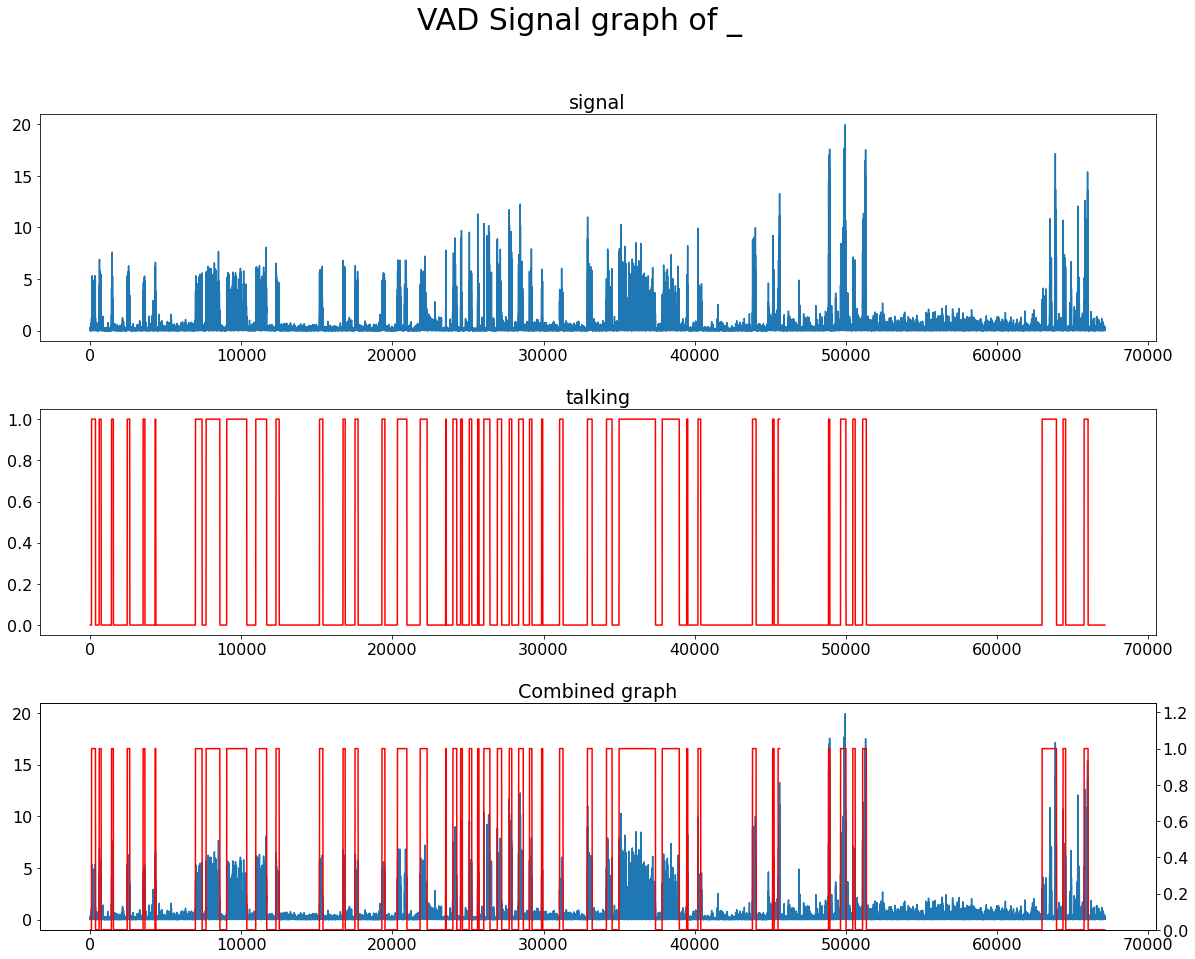

In [73]:
signal_graph(concat_new)

In [74]:
feat_new = feature_generation(concat_new)
feat_new

,person,signal,ga10,ga50,ga100,ga200,ga300,sa10,sa50,sa100,...,ma50,ma100,ma200,ma300,sd10,sd50,sd100,sd200,sd300,talking
0,1.0,0.208610,0.121107,0.101677,0.092682,0.140234,0.310320,0.167943,0.099439,-0.080665,...,0.208610,0.208610,0.208610,0.208610,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
1,1.0,0.000151,0.122707,0.101476,0.092667,0.140380,0.310475,0.154233,0.098994,-0.074337,...,0.104380,0.104380,0.104380,0.104380,0.147403,0.147403,0.147403,0.147403,0.147403,0.0
2,1.0,0.099259,0.132612,0.101081,0.092638,0.140699,0.310777,0.140524,0.098550,-0.068009,...,0.102673,0.102673,0.102673,0.102673,0.104272,0.104272,0.104272,0.104272,0.104272,0.0
3,1.0,0.119141,0.148086,0.100507,0.092592,0.141185,0.311233,0.126815,0.098105,-0.061681,...,0.106790,0.106790,0.106790,0.106790,0.085535,0.085535,0.085535,0.085535,0.085535,0.0
4,1.0,0.347784,0.153152,0.099773,0.092528,0.141830,0.311827,0.113106,0.097661,-0.055353,...,0.154989,0.154989,0.154989,0.154989,0.130778,0.130778,0.130778,0.130778,0.130778,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67150,3.0,0.300160,0.183760,0.156555,0.149668,0.148661,0.155732,0.170713,0.154107,0.132500,...,0.143046,0.160317,0.178991,0.183264,0.094660,0.101351,0.121599,0.145850,0.156977,0.0
67151,3.0,0.324791,0.181867,0.157012,0.149764,0.148637,0.155706,0.171660,0.154533,0.131946,...,0.146987,0.163026,0.178791,0.183757,0.104604,0.104525,0.122219,0.145620,0.157189,0.0
67152,3.0,0.053844,0.172718,0.157367,0.149835,0.148618,0.155685,0.172608,0.154959,0.131393,...,0.147480,0.157854,0.178713,0.183675,0.110369,0.104015,0.115537,0.145683,0.157251,0.0
67153,3.0,0.020051,0.168418,0.157609,0.149885,0.148607,0.155672,0.173556,0.155385,0.130840,...,0.142061,0.156531,0.178668,0.183182,0.116681,0.103442,0.116355,0.145731,0.157532,0.0


In [75]:
new_test_x = feat_new.iloc[:,1:-1]
new_test_y = feat_new.iloc[:, -1]

In [76]:
new_test_x

,signal,ga10,ga50,ga100,ga200,ga300,sa10,sa50,sa100,sa200,...,ma10,ma50,ma100,ma200,ma300,sd10,sd50,sd100,sd200,sd300
0,0.208610,0.121107,0.101677,0.092682,0.140234,0.310320,0.167943,0.099439,-0.080665,0.260250,...,0.208610,0.208610,0.208610,0.208610,0.208610,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000151,0.122707,0.101476,0.092667,0.140380,0.310475,0.154233,0.098994,-0.074337,0.264136,...,0.104380,0.104380,0.104380,0.104380,0.104380,0.147403,0.147403,0.147403,0.147403,0.147403
2,0.099259,0.132612,0.101081,0.092638,0.140699,0.310777,0.140524,0.098550,-0.068009,0.268021,...,0.102673,0.102673,0.102673,0.102673,0.102673,0.104272,0.104272,0.104272,0.104272,0.104272
3,0.119141,0.148086,0.100507,0.092592,0.141185,0.311233,0.126815,0.098105,-0.061681,0.271907,...,0.106790,0.106790,0.106790,0.106790,0.106790,0.085535,0.085535,0.085535,0.085535,0.085535
4,0.347784,0.153152,0.099773,0.092528,0.141830,0.311827,0.113106,0.097661,-0.055353,0.275792,...,0.154989,0.154989,0.154989,0.154989,0.154989,0.130778,0.130778,0.130778,0.130778,0.130778
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67150,0.300160,0.183760,0.156555,0.149668,0.148661,0.155732,0.170713,0.154107,0.132500,0.139408,...,0.142863,0.143046,0.160317,0.178991,0.183264,0.094660,0.101351,0.121599,0.145850,0.156977
67151,0.324791,0.181867,0.157012,0.149764,0.148637,0.155706,0.171660,0.154533,0.131946,0.138993,...,0.169958,0.146987,0.163026,0.178791,0.183757,0.104604,0.104525,0.122219,0.145620,0.157189
67152,0.053844,0.172718,0.157367,0.149835,0.148618,0.155685,0.172608,0.154959,0.131393,0.138578,...,0.162568,0.147480,0.157854,0.178713,0.183675,0.110369,0.104015,0.115537,0.145683,0.157251
67153,0.020051,0.168418,0.157609,0.149885,0.148607,0.155672,0.173556,0.155385,0.130840,0.138162,...,0.156726,0.142061,0.156531,0.178668,0.183182,0.116681,0.103442,0.116355,0.145731,0.157532


In [77]:
new_true = pd.DataFrame(new_test_y).reset_index(drop=True)
new_true.columns= ['new_smth']
true_new = new_true.copy()

In [78]:
new_lr_sm_pred_1, new_lr_origin_1 = logistic_regression(train1, new_test_x)
new_lr_sm_pred_2, new_lr_origin_2 = logistic_regression(train2, new_test_x)
new_lr_sm_pred_3, new_lr_origin_3 = logistic_regression(train3, new_test_x)

NameError: name 'logistic_regression' is not defined

In [102]:
new_lr_sm_pred_1

,new_smth
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0
...,...
67150,0.0
67151,0.0
67152,0.0
67153,0.0


In [105]:
new_turn = total_turn_taking(new_lr_sm_pred_1, new_lr_sm_pred_1, new_lr_sm_pred_3, true_new)

In [106]:
new_turn

,turn_taking
train1,36
train2,36
train3,39
true_test,44


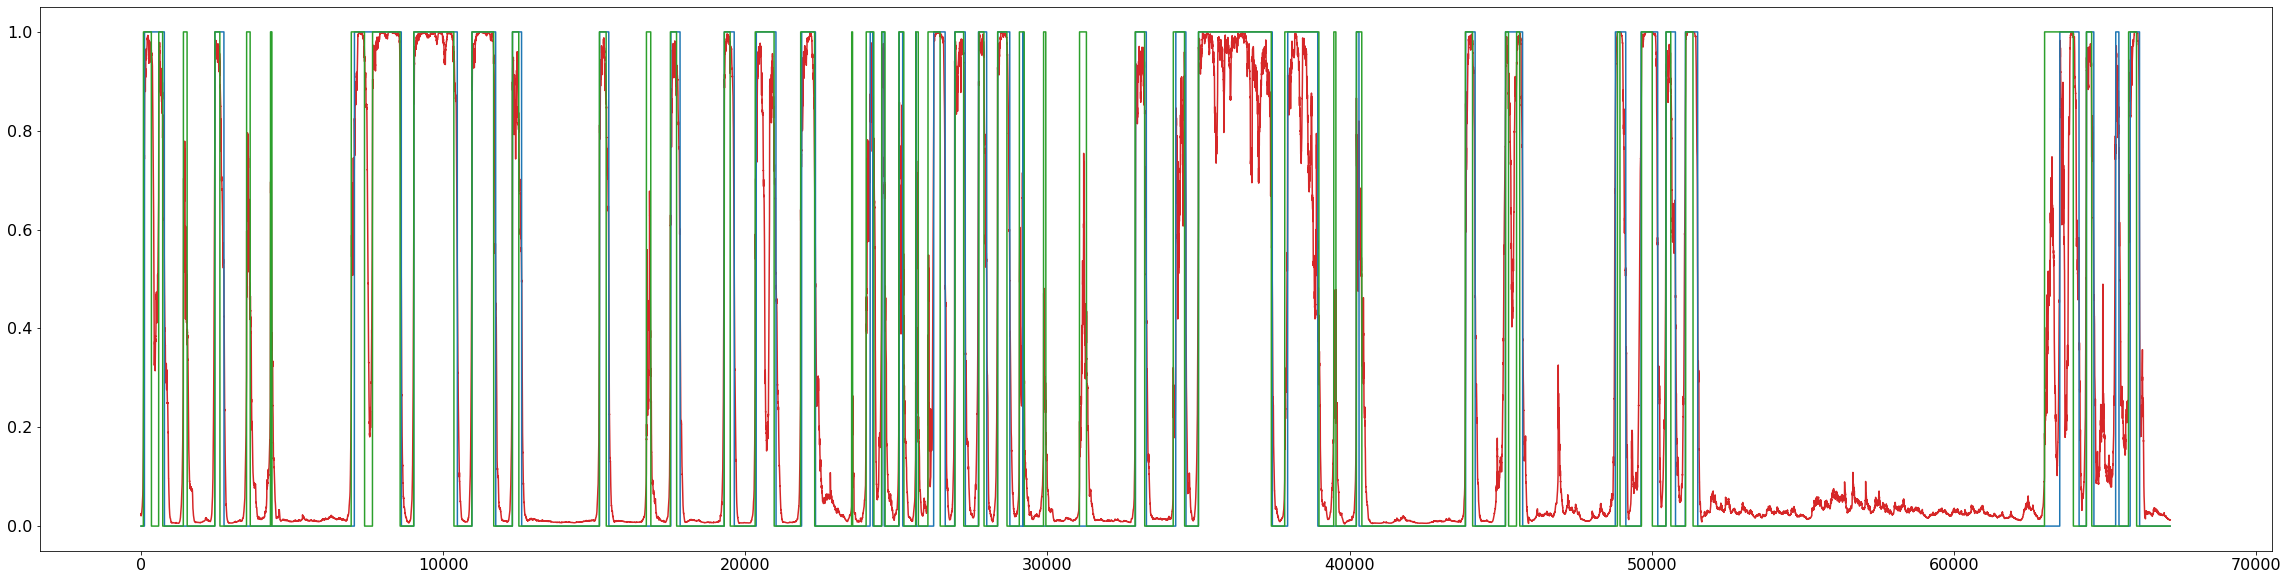

In [136]:
final_graph(0, 70000, new_lr_origin_1, new_lr_sm_pred_1, new_true)

In [128]:
result(new_true, new_lr_sm_pred_1, new_lr_sm_pred_2, new_lr_sm_pred_3)

,result,std
AUC,0.886704,0.008627
Accuracy,0.907651,0.004306
Sensitivity,0.847142,0.017352
Specificity,0.926266,0.002476


### Logistic Regression

In [79]:
from sklearn.linear_model import LogisticRegression

In [112]:
def logistic_regression(t, true_x) :
    
    lr = LogisticRegression(random_state = 0, ) 
    lr.fit(t[0].reset_index(drop=True), t[1].reset_index(drop=True)) # training 
    lr_pred = lr.predict_proba(true_x) # test 셋을 학습한 모델에 넣어서 확률값을 받는다. 
    lr_sm_pred = smoothing(lr_pred[:,1]).reset_index(drop=True)  # 확률값들을 스무딩한다. 
    lr_origin = pd.DataFrame(lr_pred[:,1]).reset_index(drop=True)
    
    return lr_pred, lr_sm_pred, lr_origin

In [119]:
train1

(         signal      ga10      ga50     ga100     ga200     ga300      sa10  \
 0      0.083206  0.064445  0.049446  0.053772  0.090414  0.233031  0.066397   
 1      0.066289  0.058647  0.049487  0.053786  0.090526  0.233164  0.062320   
 2      0.035212  0.050857  0.049570  0.053810  0.090767  0.233444  0.058243   
 3      0.032455  0.045900  0.049697  0.053846  0.091123  0.233859  0.054166   
 4      0.035212  0.046157  0.049873  0.053893  0.091612  0.234414  0.050088   
 ...         ...       ...       ...       ...       ...       ...       ...   
 21841  0.094970  0.043544  0.039861  0.048348  0.078957  0.105036  0.036624   
 21842  0.020463  0.041445  0.039764  0.048081  0.078804  0.104963  0.039905   
 21843  0.033289  0.039086  0.039692  0.047880  0.078690  0.104908  0.043187   
 21844  0.018015  0.038692  0.039644  0.047744  0.078613  0.104872  0.046469   
 21845  0.058940  0.039558  0.039619  0.047679  0.078574  0.104853  0.049750   
 
            sa50     sa100     sa200  

In [113]:
lr_pred, lr_sm_pred_1, lr_origin_1 = logistic_regression(train1, test_x)

100%|██████████| 152856/152856 [00:49<00:00, 3059.91it/s]


In [118]:
lr_pred[:,]

array([[0.99538899, 0.00461101],
       [0.994617  , 0.005383  ],
       [0.9947051 , 0.0052949 ],
       ...,
       [0.97983628, 0.02016372],
       [0.97983853, 0.02016147],
       [0.97998068, 0.02001932]])

In [83]:
lr_sm_pred_2, lr_origin_2 = logistic_regression(train2, test_x)

100%|██████████| 152856/152856 [00:53<00:00, 2866.20it/s]


In [84]:
lr_sm_pred_3, lr_origin_3 = logistic_regression(train3, test_x)

100%|██████████| 152856/152856 [00:52<00:00, 2937.98it/s]


In [85]:
lr_sm_pred_1

,new_smth
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0
...,...
152851,0.0
152852,0.0
152853,0.0
152854,0.0


In [86]:
ttt = total_turn_taking(lr_sm_pred_1, lr_sm_pred_1, lr_sm_pred_3, true_test)

In [87]:
ttt

,turn_taking
train1,49
train2,49
train3,49
true_test,37


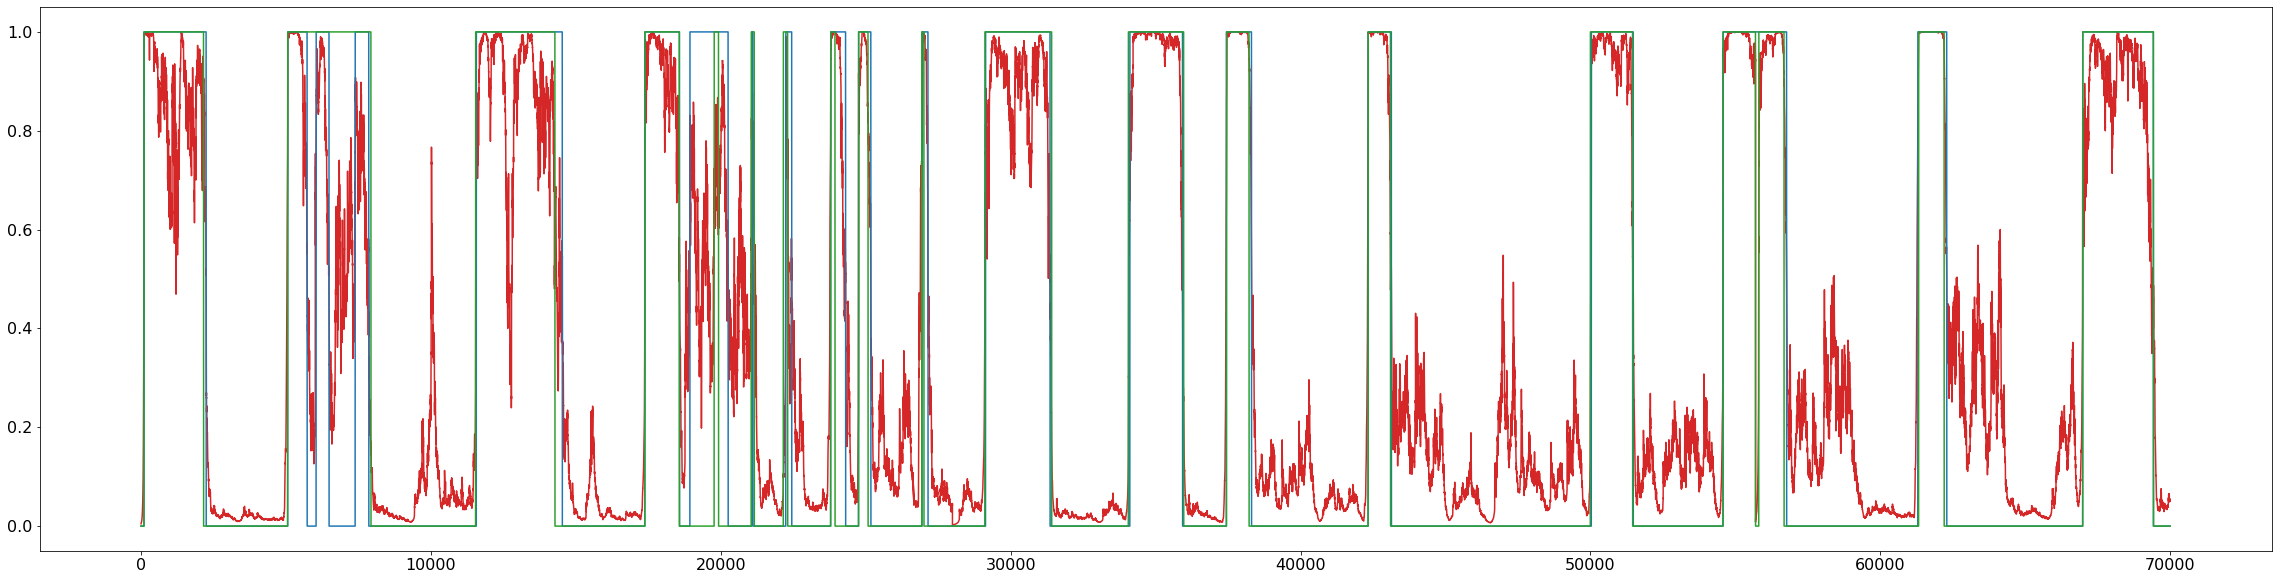

In [91]:
final_graph(0, 70000, lr_origin_1, lr_sm_pred_1, true_test)

In [92]:
lr_sm_pred_2.shape

(152856, 1)

In [93]:
result(true_test,lr_sm_pred_1, lr_sm_pred_2, lr_sm_pred_3)

,result,std
AUC,0.922938,0.005823
Accuracy,0.923071,0.007478
Sensitivity,0.921783,0.016118
Specificity,0.924094,0.023566


In [94]:
def choice(df_total_turn_taking):
    
    a = int(abs(df_total_turn_taking.loc['train1', :] - df_total_turn_taking.loc['true_test', :]))
    b = int(abs(df_total_turn_taking.loc['train2',:] - df_total_turn_taking.loc['true_test', :]))
    c = int(abs(df_total_turn_taking.loc['train3', :] - df_total_turn_taking.loc['true_test', :]))

    thus = pd.DataFrame([a,b,c], columns = ['sub'])
    thus.index = ['train1', 'train2', 'train3']
    total = pd.concat([df_total_turn_taking.iloc[:3, :], thus], axis = 1)

    condition = min(total.loc[:, 'sub'])
    ccc = list(total[total.loc[:, 'sub'] == condition].index)
    return ccc

In [95]:
ch = choice(ttt)
ch

['train1', 'train2', 'train3']

In [96]:
# ch 결과가 한개면, 해당 lr_sm_pred_# 왼쪽에 test_idx를 붙여준다. 

def person_smth_1(uni,pred1, pred2, pred3, true):
    condition1 = int(str(uni)[7])
    cond_idx = condition1 - 1
    con = pd.concat([pred1, pred2, pred3], axis = 1).reset_index(drop = True)
    con.columns = ['1', '2', '3']
    r = con.iloc[:, cond_idx]
    pls = pd.concat([true, r], axis = 1).reset_index(drop= True)
    return pls

In [97]:
person_smth_1(ch,lr_sm_pred_1, lr_sm_pred_2, lr_sm_pred_3, test_idx )

,person,1
0,1.0,0.0
1,1.0,0.0
2,1.0,0.0
3,1.0,0.0
4,1.0,0.0
...,...,...
152851,3.0,0.0
152852,3.0,0.0
152853,3.0,0.0
152854,3.0,0.0


In [98]:
# ccc 중에서 result 성능이 제일 좋은거를 골라서 lr_sm_pred# 왼쪽에 붙여 준다. 

In [99]:
test_idx

0         1.0
1         1.0
2         1.0
3         1.0
4         1.0
         ... 
152851    3.0
152852    3.0
152853    3.0
152854    3.0
152855    3.0
Name: person, Length: 152856, dtype: float64

In [66]:
# pred1, pred2, pred3 각각에 대한 Accuracy 뽑아 내는걸로 만들자. 
# aa, bb, cc, 중에서 가장 큰 값의 인덱스를 뽑아낸다. 
# 그 인덱스에 해당하는 lr_sm_pred_1을 뱉어주자.

def Accuracy_detail(test, pred1, pred2, pred3):
    aa = accuracy_score(test, pred1)
    bb = accuracy_score(test, pred2)
    cc = accuracy_score(test, pred3)    
    
    # qq 로 데이터 프레임 만들어주고
    # accuracy 중에서 제일 높은 row의 index를 보내준다. 
    qq = pd.DataFrame([aa, bb, cc], index =['train1', 'train2', 'train3'] )
    qq.columns = ['accuracy']
    condition = max(qq.loc[:, 'accuracy'])
    to = list(qq[qq.loc[:, 'accuracy'] == condition].index)
    
    return to

In [67]:
w = Accuracy_detail(true_test,lr_sm_pred_1, lr_sm_pred_2, lr_sm_pred_3)
w

['train2']

In [68]:
## accuracy는 어차피 하나만 나오니까. 하나에 대해서만 test_idx 
## 함수로 만들어야 한다!!!
## 모델 별로 lr_sm_pred_1 앞 부분이 달라지기 때문에, function으로 만들어야한다. input 은 lr_sm_pred_1,2,3이 되겠다.
## 
w = Accuracy_detail(true_test,lr_sm_pred_1, lr_sm_pred_2, lr_sm_pred_3)
def person_smth_2(multi,pred1, pred2, pred3, true):
    condition1 = int(str(multi)[7])
    cond_idx = condition1 - 1
    con = pd.concat([pred1, pred2, pred3], axis = 1).reset_index(drop = True)
    con.columns = ['1', '2', '3']
    r = con.iloc[:, cond_idx]
    pls = pd.concat([true, r], axis = 1).reset_index(drop= True)
    return pls

In [70]:
person_smth_1(w, lr_sm_pred_1, lr_sm_pred_2, lr_sm_pred_3, test_idx)

,person,2
0,1.0,0.0
1,1.0,0.0
2,1.0,0.0
3,1.0,0.0
4,1.0,0.0
...,...,...
155122,3.0,0.0
155123,3.0,0.0
155124,3.0,0.0
155125,3.0,0.0


In [268]:
if len(choice(ttt)) == 1:
    a = person_smth_1(ch, lr_sm_pred_1, lr_sm_pred_2, lr_sm_pred_3, test_idx)
    print(a,'a')
else:
    w = Accuracy_detail(true_test,lr_sm_pred_1, lr_sm_pred_2, lr_sm_pred_3)
    m = person_smth(w, lr_sm_pred_1, lr_sm_pred_2, lr_sm_pred_3, test_idx)
    print(m, 'm')

        person    3
0          1.0  0.0
1          1.0  0.0
2          1.0  0.0
3          1.0  0.0
4          1.0  0.0
...        ...  ...
155122     3.0  0.0
155123     3.0  0.0
155124     3.0  0.0
155125     3.0  0.0
155126     3.0  0.0

[155127 rows x 2 columns] a


In [270]:
a.columns = ["person", "talking"]

In [274]:
def simul_dividing(df) :
    per1 = df[df["person"] == 1]
    per1 = per1.reset_index(drop = True)
    per1.columns = ["person_1", "talking_1"]
    
    per2 = df[df["person"] == 2]
    per2 = per2.reset_index(drop = True)
    per2.columns = ["person_2", "talking_2"]
    
    per3 = df[df["person"] == 3]
    per3 = per3.reset_index(drop = True)
    per3.columns = ["person_3", "talking_3"]
    
    df_talking = pd.concat([per1_talk, per2_talk, per3_talk], axis = 1)
    return df_talking

In [277]:
df_simul = simul_dividing(a)

In [327]:
def adding_sum_of_talking (df):
    sum_of_talk = df.sum(axis = 1)
    df_sum_of =  pd.concat([df, sum_of_talk], axis = 1)
    df_sum_of.columns = ["talking_1", "talking_2", "talking_3", "sum_of_talk"]
    return df_sum_of

In [697]:
mamison= adding_sum_of_talking(df_simul)

In [698]:
mamison

,talking_1,talking_2,talking_3,sum_of_talk
0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0
...,...,...,...,...
51704,0.0,0.0,0.0,0.0
51705,0.0,0.0,0.0,0.0
51706,0.0,0.0,0.0,0.0
51707,0.0,0.0,0.0,0.0


In [699]:
mm = mamison.drop(["sum_of_talk"], axis=1)

In [700]:
mm

,talking_1,talking_2,talking_3
0,0.0,0.0,0.0
1,0.0,0.0,0.0
2,0.0,0.0,0.0
3,0.0,0.0,0.0
4,0.0,0.0,0.0
...,...,...,...
51704,0.0,0.0,0.0
51705,0.0,0.0,0.0
51706,0.0,0.0,0.0
51707,0.0,0.0,0.0


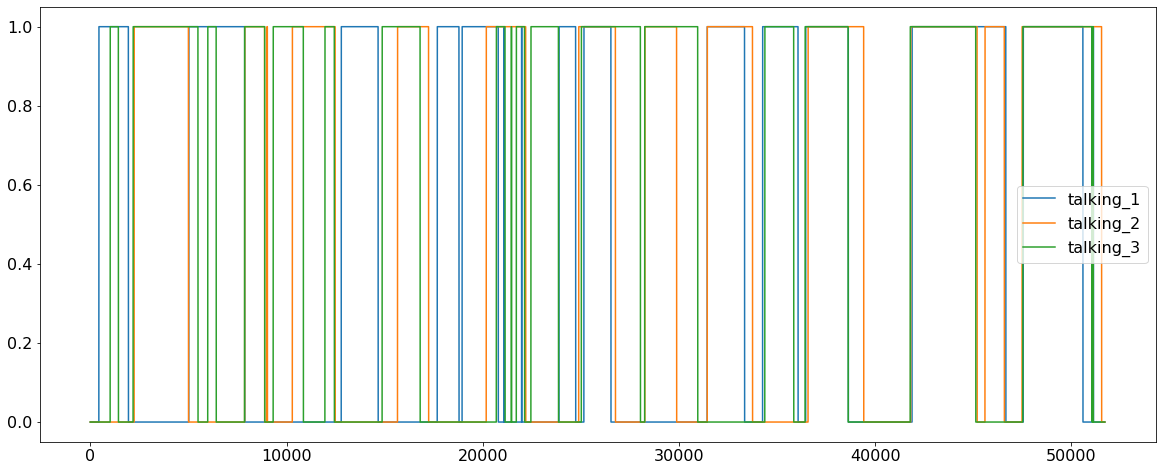

In [701]:
mm.plot()

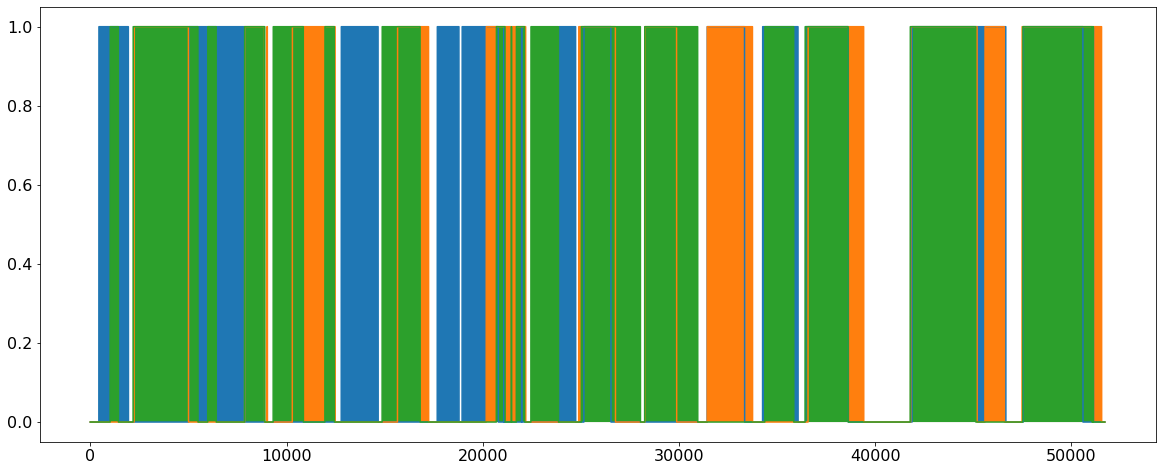

In [702]:
plt.plot(mm)
plt.rcParams["figure.figsize"] = (20,8)
plt.fill(mm)

In [703]:
def removing_all_zero(df):
    df_2 = df
    for i in range(len(df_2)):
        try : 
            if (df_2["sum_of_talk"][i] == 0 ):
                df_2.drop(index = i, inplace = True)
                new_df = df_2.reset_index(drop = True)
        except KeyError:
            print('input 선언을 다시하시오')
    return new_df

In [704]:
one_shu = removing_all_zero(mamison)

In [380]:
def turn_1_to_2 (df):
    count_1_to_2 = 0
    for i in range(len(df)) :
        try :
            if df.loc[i, 'talking_1'] - df.loc[i+1, 'talking_1'] == 1 :
                if df.loc[i, 'talking_2'] - df.loc[i+1, 'talking_2'] == -1 : 
                    count_1_to_2 = count_1_to_2 + 1
        except KeyError :
            count_1_to_2 = count_1_to_2 + 0
    return count_1_to_2

In [381]:
def turn_1_to_3 (df) :
    count_1_to_3 = 0
    for i in range(len(df)) :
        try :
            if df.loc[i, 'talking_1'] - df.loc[i+1, 'talking_1'] == 1 :
                if df.loc[i, 'talking_3'] -df.loc[i+1, 'talking_3'] == -1 : 
                    count_1_to_3 = count_1_to_3 + 1
        except KeyError :
            count_1_to_3 = count_1_to_3 + 0
    return count_1_to_3

In [382]:
def turn_2_to_1 (df) : 
    count_2_to_1 = 0
    for i in range(len(df)) :
        try :
            if df.loc[i, 'talking_2'] - df.loc[i+1, 'talking_2'] == 1 :
                if df.loc[i, 'talking_1'] - df.loc[i+1, 'talking_1'] == -1 : 
                    count_2_to_1 = count_2_to_1 + 1
        except KeyError :
            count_2_to_1 = count_2_to_1 + 0
    return count_2_to_1

In [383]:
def turn_2_to_3 (df) : 
    count_2_to_3 = 0
    for i in range(len(df)) :
        try :
            if df.loc[i, 'talking_2'] - df.loc[i+1, 'talking_2'] == 1 :
                if df.loc[i, 'talking_3'] - df.loc[i+1, 'talking_3'] == -1 : 
                    count_2_to_3 = count_2_to_3 + 1
        except KeyError :
            count_2_to_3 = count_2_to_3 + 0
    return count_2_to_3

In [384]:
def turn_3_to_1 (df) : 
    count_3_to_1 = 0
    for i in range(len(df)) :
        try :
            if df.loc[i, 'talking_3'] - df.loc[i+1, 'talking_3'] == 1 :
                if df.loc[i, 'talking_1'] - df.loc[i+1, 'talking_1'] == -1 : 
                    count_3_to_1 = count_3_to_1 + 1
        except KeyError :
            count_3_to_1 = count_3_to_1 + 0
    return count_3_to_1

In [385]:
def turn_3_to_2 (df) : 
    count_3_to_2 = 0
    for i in range(len(df)) :
        try :
            if df.loc[i, 'talking_3'] - df.loc[i+1, 'talking_3'] == 1 :
                if df.loc[i, 'talking_2'] - df.loc[i+1, 'talking_2'] == -1 : 
                    count_3_to_2 = count_3_to_2 + 1
        except KeyError :
            count_3_to_2 = count_3_to_2 + 0
    return count_3_to_2

In [386]:
turn_1_to_2(one_shu)

2

In [387]:
turn_1_to_3(one_shu)

3

In [388]:
turn_2_to_1(one_shu)

3

In [389]:
turn_2_to_3(one_shu)

3

In [390]:
turn_3_to_1(one_shu)

2

In [391]:
turn_3_to_2(one_shu)

1

In [408]:
def dyndic_level_variable (df, number_of_members):
    a = turn_1_to_2(df)
    b = turn_1_to_3(df)
    c = turn_2_to_1(df)
    d = turn_2_to_3(df)
    e = turn_3_to_1(df)
    f = turn_3_to_2(df)
    
    data = [('person_1', a+b, a, b),
            ('person_2', c, c+d, d),
            ('person_3', e, f, e+f)]
    
    table = pd.DataFrame(data)
    table.columns = [' ', 'person_1', 'person_2', 'person_3']
    table = table.set_index(' ')
    
    avg_turn = ((a+b) + (c+d) +(e+f))/ number_of_members 
    equality = (((a+b) - avg_turn) ** 2 + ((c+d) - avg_turn)** 2 + ((e+f) - avg_turn)**2)/ number_of_members
    print('The equality of turn taking :', equality)
    print(" ")
    
    return table

In [409]:
dyndic_level_variable(one_shu, 3)

The equality of turn taking : 1.5555555555555554
 


,person_1,person_2,person_3
,,,
person_1,5,2,3
person_2,3,6,3
person_3,2,1,3


In [663]:
one_shu.to_csv("removing_zero.csv")

In [447]:
def speaking_time(df, number_of_members) : 
    speak = df.sum()
    df_spt = pd.DataFrame(speak)
    speak_second= df_spt[0] * (1/100)
    # sp_time = pd.concat([df_spt,speak_second], axis =1)
    # sp_time.columns = ["1/100 Hz", "seconds"]
    
    a = turn_1_to_2(df)
    b = turn_1_to_3(df)
    c = turn_2_to_1(df)
    d = turn_2_to_3(df)
    e = turn_3_to_1(df)
    f = turn_3_to_2(df)
    
    p1_avg_speaking = speak_second[0] * (1/(a+b))
    p2_avg_speaking = speak_second[1] * (1/(c+d))
    p3_avg_speaking = speak_second[2] * (1/(e+f))
    total_avg_speaking = speak_second[3] * (1/(a+b+c+d+e+f))
    avg_speaking = [(p1_avg_speaking), 
                    (p2_avg_speaking), 
                    (p3_avg_speaking), 
                    (total_avg_speaking)]
    avg_speaking = pd.DataFrame(avg_speaking, index = ['talking_1', 'talking_2', 'talking_3', 'sum_of_talk'])
    
    sp_time = pd.concat([df_spt, speak_second, avg_speaking], axis =1)
    sp_time.columns = ["1/100 Hz", "seconds", "average speak"]
    
    avg_team_speaking = sp_time["average speak"][3]
    
    equality = ((sp_time["seconds"][0] - avg_team_speaking) ** 2 + (sp_time["seconds"][1] - avg_team_speaking)** 2 + (sp_time["seconds"][2] - avg_team_speaking)**2)/ number_of_members
    print('The equality of speaking :', equality)
    print(" ")
    return sp_time
    

In [449]:
speaking_time(one_shu, 3)

The equality of speaking : 43377.88416666666
 


,1/100 Hz,seconds,average speak
talking_1,25119.0,251.19,50.238000
talking_2,26633.0,266.33,44.388333
talking_3,27670.0,276.70,92.233333
sum_of_talk,79422.0,794.22,56.730000


In [705]:
mm

,talking_1,talking_2,talking_3
0,0.0,0.0,0.0
1,0.0,0.0,0.0
2,0.0,0.0,0.0
3,0.0,0.0,0.0
4,0.0,0.0,0.0
...,...,...,...
51704,0.0,0.0,0.0
51705,0.0,0.0,0.0
51706,0.0,0.0,0.0
51707,0.0,0.0,0.0


In [706]:
new_mm = mm

In [707]:
new_mm

,talking_1,talking_2,talking_3
0,0.0,0.0,0.0
1,0.0,0.0,0.0
2,0.0,0.0,0.0
3,0.0,0.0,0.0
4,0.0,0.0,0.0
...,...,...,...
51704,0.0,0.0,0.0
51705,0.0,0.0,0.0
51706,0.0,0.0,0.0
51707,0.0,0.0,0.0


In [528]:
any(new_mm.iloc[0:300, 0]) == 0

True

In [533]:
for i in tqdm(range(len(new_mm))) :
    if new_mm.iloc[i, 0] == 0 : 
        if any(new_mm.iloc[i: i+300, 0]) == 0 :
            new_mm.iloc[i, 0] = '침묵'

100%|██████████| 51709/51709 [00:16<00:00, 3186.79it/s]


In [696]:
new_mm.head(5100)

,talking_1,talking_2,talking_3
0,침묵,침묵,침묵
1,침묵,침묵,침묵
2,침묵,침묵,침묵
3,침묵,침묵,침묵
4,침묵,침묵,침묵
...,...,...,...
5095,침묵,침묵,침묵
5096,침묵,침묵,침묵
5097,침묵,침묵,침묵
5098,침묵,침묵,침묵


In [574]:
new_mm.to_csv("testtest.csv")

In [708]:
def silence (df, person_who) :
    person_who = person_who -1
    cum_count = 0 
    start_idx = []
    end_idx= []

    for i in range(len(df)) :
        if i+1 != len(df) :
            if new_mm.iloc[i, person_who] == 0 :
                if cum_count == 0 :
                    start_idx.append(i)
                    cum_count += 1
                else :
                    cum_count += 1

            elif new_mm.iloc[i, person_who] == 1 :
                if cum_count >= 300 :
                    end_idx.append(i-1)
                    cum_count = 0

        elif i+1 == len(df) :
            end_idx.append(i)
        
    df_st = pd.DataFrame(start_idx)
    df_st.columns = ["start_idx"]
    df_ed = pd.DataFrame(end_idx)
    df_ed.columns = ["end_idx"]
    
    df_concat = pd.concat([df_st, df_ed], axis = 1)
    
    for j in range(len( )) :
    
    return df_concat

IndentationError: expected an indented block (<ipython-input-708-03ea9455b498>, line 33)

In [710]:
o = silence(new_mm, 1)

In [711]:
o

,start_idx,end_idx
0,0,435
1,1940,5019
2,7869,12788
3,14668,17681
4,18789,21096
5,21098,21980
6,21986,23888
7,24735,25155
8,26533,31438
9,33344,34263


In [712]:
o["start_idx"][0]

0

In [713]:
ani = new_mm

In [714]:
ani

,talking_1,talking_2,talking_3
0,0.0,0.0,0.0
1,0.0,0.0,0.0
2,0.0,0.0,0.0
3,0.0,0.0,0.0
4,0.0,0.0,0.0
...,...,...,...
51704,0.0,0.0,0.0
51705,0.0,0.0,0.0
51706,0.0,0.0,0.0
51707,0.0,0.0,0.0


In [717]:
for i in range(len(o)) :
    start = o["start_idx"][i]
    print(start)
    end = o["end_idx"][i]
    print(end)
     
    ani.iloc[start:end, 0] = "침묵"
    ani.iloc[start:end, 1] = "침묵"
    ani.iloc[start:end, 2] = "침묵"

0
435
1940
5019
7869
12788
14668
17681
18789
21096
21098
21980
21986
23888
24735
25155
26533
31438
33344
34263
36070
36460
38632
41881
46660
47547
50589
51116
51125
51708


In [718]:
ani.head(5000)

,talking_1,talking_2,talking_3
0,침묵,침묵,침묵
1,침묵,침묵,침묵
2,침묵,침묵,침묵
3,침묵,침묵,침묵
4,침묵,침묵,침묵
...,...,...,...
4995,침묵,침묵,침묵
4996,침묵,침묵,침묵
4997,침묵,침묵,침묵
4998,침묵,침묵,침묵


In [719]:
ani.to_csv("ani.csv")

____________________________________________________

____________________________________________________

In [73]:
## a 에서 1 인 row만 건져낸다. 
### 그 중에서 300이하로 지속된 1 의 row도 제거한다. --> 대략 350 구간 동안 1이 지속된 row만 건져온다.


In [74]:
# for loop돌면서 아래 index value의 값을 가져오게 한다. 
a.index.values

array([     0,      1,      2, ..., 155124, 155125, 155126])

In [75]:
a_prime = a.copy()
cong = a_prime[a_prime.iloc[:, 1] == 1]
cong

,person,3
436,1.0,1.0
437,1.0,1.0
438,1.0,1.0
439,1.0,1.0
440,1.0,1.0
...,...,...
154528,3.0,1.0
154529,3.0,1.0
154530,3.0,1.0
154531,3.0,1.0


In [76]:
cong.loc[10:309, '3']

Series([], Name: 3, dtype: float64)

In [77]:
ah = cong.index.values

In [79]:
cong

,person,3
436,1.0,1.0
437,1.0,1.0
438,1.0,1.0
439,1.0,1.0
440,1.0,1.0
...,...,...
154528,3.0,1.0
154529,3.0,1.0
154530,3.0,1.0
154531,3.0,1.0


In [111]:
random_forest()

NameError: name 'rf' is not defined

### Random Forest

In [100]:
from sklearn.ensemble import RandomForestClassifier

In [101]:
def random_forest(t, true_x) :
    rf = RandomForestClassifier(max_depth = 100 ,random_state=0)
    rf.fit(t[0], t[1])
    rf_pred = rf.predict_proba(true_x)
    rf_sm_pred = smoothing(rf_pred[:,1])  # 확률값들을 스무딩한다. 
    rf_origin = pd.DataFrame(rf_pred[:,1]).reset_index(drop=True)
    
    return rf_sm_pred, rf_origin

In [102]:
rf_sm_pred_1, rf_origin_1= random_forest(train1, test_x)

100%|██████████| 152856/152856 [00:47<00:00, 3195.83it/s]


In [103]:
rf_sm_pred_2, rf_origin_2= random_forest(train2, test_x)

100%|██████████| 152856/152856 [00:51<00:00, 2994.52it/s]


In [104]:
rf_sm_pred_3, rf_origin_3= random_forest(train3, test_x)

100%|██████████| 152856/152856 [00:49<00:00, 3063.97it/s]


In [105]:
total_turn_taking(rf_sm_pred_1, rf_sm_pred_2, rf_sm_pred_3, true_test)

,turn_taking
train1,46
train2,50
train3,49
true_test,37


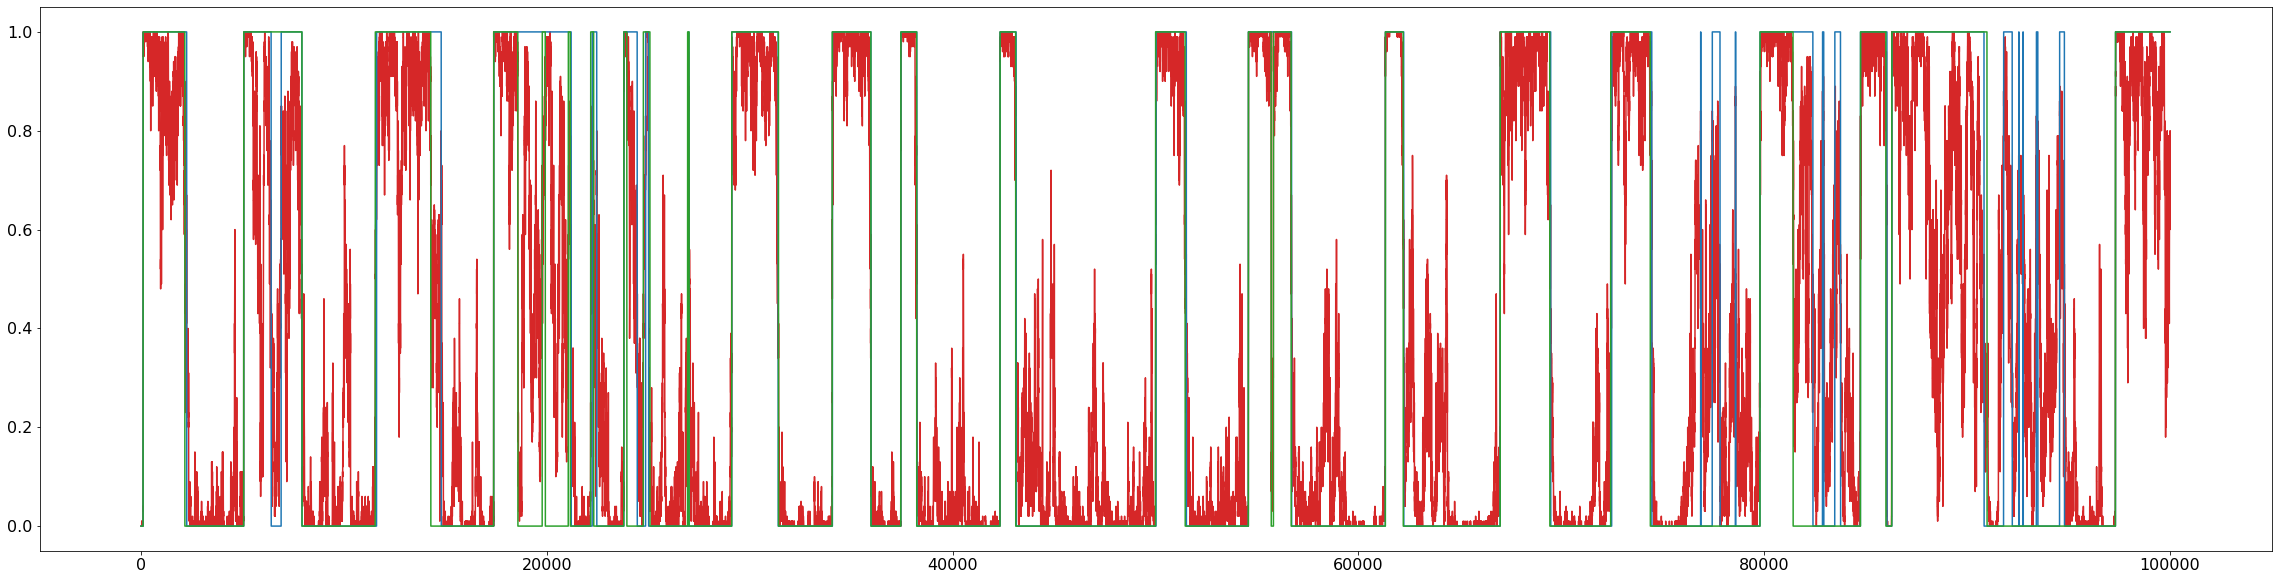

In [107]:
final_graph(0, 100000, rf_origin_1, rf_sm_pred_1, true_test)

In [108]:
result(true_test,rf_sm_pred_1, rf_sm_pred_2, rf_sm_pred_3)

,result,std
AUC,0.917748,0.014359
Accuracy,0.912857,0.016201
Sensitivity,0.960167,0.001899
Specificity,0.875330,0.030342


### Neural Networks

In [ ]:
from sklearn.neural_network import MLPClassifier

In [ ]:
def neural_network(t, true_x) :
    nn = MLPClassifier(hidden_layer_sizes=3 , max_iter=100)
    nn.fit(t[0], t[1])
    nn_pred = nn.predict_proba(true_x)
    nn_sm_pred = smoothing(nn_pred[:,1])  # 확률값들을 스무딩한다. 
    nn_origin = pd.DataFrame(nn_pred[:,1]).reset_index(drop=True)
    
    return nn_sm_pred, nn_origin

In [ ]:
nn_sm_pred_1, nn_origin_1= neural_network(train1, test_x)

In [ ]:
nn_sm_pred_2, nn_origin_2= neural_network(train2, test_x)

In [ ]:
nn_sm_pred_3, nn_origin_3= neural_network(train3, test_x)

In [ ]:
total_turn_taking(nn_sm_pred_1, nn_sm_pred_2, nn_sm_pred_3, true_test)

In [ ]:
final_graph(nn_origin_1, nn_sm_pred_1, true_test)

In [ ]:
result(true_test,nn_sm_pred_1, nn_sm_pred_2, nn_sm_pred_3)

### Gradient Boosting

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

In [ ]:
def gradient_boosting(t, true_x) :
    grb = GradientBoostingClassifier(n_estimators=50, random_state=0)
    grb.fit(t[0], t[1])
    grb_pred = grb.predict_proba(true_x)
    grb_sm_pred = smoothing(grb_pred[:,1])  # 확률값들을 스무딩한다. 
    grb_origin = pd.DataFrame(grb_pred[:,1]).reset_index(drop=True)
    
    return grb_sm_pred, grb_origin

In [ ]:
grb_sm_pred_1, grb_origin_1 = gradient_boosting(train1,test_x)

In [ ]:
grb_sm_pred_2, grb_origin_2 = gradient_boosting(train2, test_x)

In [ ]:
grb_sm_pred_3, grb_origin_3 = gradient_boosting(train3, test_x)

In [ ]:
total_turn_taking(grb_sm_pred_1, grb_sm_pred_2, grb_sm_pred_3, true_test)

In [ ]:
final_graph(grb_origin_1, grb_sm_pred_1, true_test)

In [ ]:
result(true_test,grb_sm_pred_1, grb_sm_pred_2, grb_sm_pred_3)

### LDA

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [ ]:
def LDA(t, true_x) :
    lda = LinearDiscriminantAnalysis()
    lda.fit(t[0], t[1])
    lda_pred = lda.predict_proba(true_x)
#     print(lda_pred[:,0])
    lda_sm_pred = smoothing(lda_pred[:,1])
    lda_origin = pd.DataFrame(lda_pred[:,1]).reset_index(drop=True)
    
    return lda_sm_pred, lda_origin

In [ ]:
lda_sm_pred_1, lda_origin_1 = LDA(train1, test_x)

In [ ]:
lda_sm_pred_2, lda_origin_2 = LDA(train2, test_x)

In [ ]:
lda_sm_pred_3, lda_origin_3 = LDA(train3, test_x)

In [ ]:
total_turn_taking(lda_sm_pred_1, lda_sm_pred_2, lda_sm_pred_3, true_test)

In [ ]:
final_graph(lda_origin_1, lda_sm_pred_1, true_test)

In [ ]:
result(true_test,lda_sm_pred_1, lda_sm_pred_2, lda_sm_pred_3)

### Naive Bayes (사용 x)

In [ ]:
from sklearn.naive_bayes import GaussianNB

In [ ]:
def naive_bayes(t) :
    nb = GaussianNB()
    nb.fit(t[0], t[1])
    nb_pred = nb.predict_proba(test_x)
    nb_sm_pred = smoothing(nb_pred[:,0])  # 확률값들을 스무딩한다. 
    nb_origin = pd.DataFrame(nb_pred[:,0]).reset_index(drop=True)
    
    return nb_sm_pred, nb_origin

In [ ]:
nb_sm_pred_1, nb_origin_1 = naive_bayes(train1)

In [ ]:
nb_sm_pred_2, nb_origin_2 = naive_bayes(train2)

In [ ]:
nb_sm_pred_3, nb_origin_3 = naive_bayes(train3)

In [ ]:
total_turn_taking(nb_sm_pred_1, nb_sm_pred_2, nb_sm_pred_3, true_test)

In [ ]:
final_graph(nb_origin_1, nb_sm_pred_1, true_test)

### Linear SVM (사용 x)

In [ ]:
from sklearn.svm import LinearSVC

In [ ]:
def lienar_svm(t) :
    lsvm= LinearSVC(random_state=0, tol=1e-5)
    lsvm.fit(t[0], t[1])
    #lsvm_pred = lsvm.predict_proba(test_x)
    lsvm_pred = lsvm.predict(test_x)
    #lsvm_sm_pred = smoothing(lsvm_pred)  # 확률값들을 스무딩한다. 
    lsvm_origin = pd.DataFrame(lsvm_pred).reset_index(drop=True)
    
    return lsvm_pred, lsvm_origin

In [ ]:
lsvm_pred_1, lsvm_origin_1 = lienar_svm(train1)

In [ ]:
lsvm_pred_2, lsvm_origin_2 = lienar_svm(train2)

In [ ]:
lsvm_pred_3, lsvm_origin_3 = lienar_svm(train3)

In [ ]:
def final_graph_lsvm (origin, sm_pred, true_test): #graph
    plt.figure(figsize=(40,10))
    plt.plot(origin[:], color='tab:red')
    plt.plot(sm_pred[:], color='tab:blue')
    plt.plot(true_test['new_smth'][:], color = 'tab:green')

In [ ]:
final_graph_lsvm(lsvm_origin_1, lsvm_pred_1, true_test)